#CHECKGPT DATASET (SAME AS THE ORIGINAL PAPER) WAS USED FOR FINE-TUNING AUTHORMIST

In [ ]:
!git clone https://github.com/liuzey/CheckGPT-v2.git

Cloning into 'CheckGPT-v2'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 145 (delta 14), reused 29 (delta 9), pack-reused 107 (from 1)
Receiving objects: 100% (145/145), 1.10 GiB | 27.91 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (68/68), done.


In [ ]:
!pip install datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Imports

In [ ]:
from transformers import (pipeline, AutoTokenizer, AutoModel, AutoModelForCausalLM)
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import argparse
import gc
from datasets import Dataset
from trl import GRPOConfig, GRPOTrainer
from sklearn.model_selection import train_test_split
import json
import os
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig

In [ ]:
# Clear memory at start
gc.collect()
torch.cuda.empty_cache()

### Preparing the dataset using CHECKGPT

In [ ]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Function to create paraphrase prompt
def create_paraphrase_prompt(text: str) -> str:
    return f"""Please paraphrase the following text to make it more human-like while preserving the original meaning:
{text}
Paraphrased text:"""

# Load and prepare data
print("Loading data...")

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

# Limit dataset size to prevent OOM
max_samples = 300
if len(ai_texts) > max_samples:
    print(f"Limiting dataset to {max_samples} samples to prevent OOM")
    ai_texts = ai_texts[:max_samples]

# Split AI texts into train/test
train_texts, test_texts = train_test_split(ai_texts, test_size=0.2, random_state=42)

# Attach paraphrasing prompt to AI texts
train_texts = [create_paraphrase_prompt(text) for text in train_texts]
test_texts = [create_paraphrase_prompt(text) for text in test_texts]

# Create datasets
train_dataset = Dataset.from_dict({"prompt": train_texts})
test_dataset = Dataset.from_dict({"prompt": test_texts})

print(f"Training samples: {len(train_texts)}")

Loading data...
Limiting dataset to 300 samples to prevent OOM
Training samples: 240


### GRPO Config being setup along with PEFT

In [ ]:
# Initialize the RADAR detector as None - will be loaded on first use
radar_detector = None

# Configure training with optimized settings for memory efficiency
print("Configuring training...")
training_args = GRPOConfig(
    output_dir="checkpoints/",
    logging_steps=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    fp16=True,
    optim="adamw_torch",
    gradient_checkpointing=True,
    max_grad_norm=0.5,
    remove_unused_columns=False,
    dataloader_num_workers=1,
    save_total_limit=1,
    save_strategy="epoch",
    eval_strategy="no",
    num_generations=2,
)

# Define PEFT configuration for LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=128,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

Configuring training...


### RADAR and DetectGPT are used as detectors along with the SemanticSimilarityChecker

In [ ]:
# Define multiple detector classes
class Radar():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading RADAR model...")
            self.judge_model = pipeline(
                "text-classification",
                model="TrustSafeAI/RADAR-Vicuna-7B",
                tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("RADAR model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "LABEL_0" else 1 - score["score"])
            for score in scores
        ]

# Add another detector class (example for an OpenAI-based detector)
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

# Add a semantic similarity checker
class SemanticSimilarityChecker():
    def __init__(self, device="cpu"):
        self.device = device
        self.model = None
        self.tokenizer = None

    def _load_model(self):
        if self.model is None:
            print("Loading Semantic Similarity model...")
            self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
            print("Semantic Similarity model loaded successfully")

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, texts):
        self._load_model()
        encoded_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(self.device)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return self._mean_pooling(model_output, encoded_input['attention_mask'])

    def compute_similarity(self, original_texts, paraphrased_texts):
        # Get original texts from prompts (assuming prompt format is the same as in your code)
        extracted_originals = []
        for prompt in original_texts:
            text_start = prompt.find("following text:") + len("following text:")
            text_end = prompt.find("Paraphrased text:")
            extracted_originals.append(prompt[text_start:text_end].strip())

        original_embeddings = self.get_embeddings(extracted_originals)
        paraphrased_embeddings = self.get_embeddings(paraphrased_texts)

        # Compute cosine similarity
        similarities = []
        for i in range(len(original_embeddings)):
            similarity = F.cosine_similarity(original_embeddings[i].unsqueeze(0),
                                            paraphrased_embeddings[i].unsqueeze(0)).item()
            similarities.append(similarity)

        return similarities

# Initialize all detectors as None - will be loaded on first use
radar_detector = None
detectgpt_detector = None
semantic_checker = None

# Define a comprehensive reward function that combines multiple detectors
def multi_detector_reward_func(completions, prompts=None, **kwargs):
    global radar_detector, detectgpt_detector, semantic_checker

    # Initialize detectors if needed
    if radar_detector is None:
        radar_detector = Radar(device="cpu")
    if detectgpt_detector is None:
        detectgpt_detector = DetectGPT(device="cpu")
    if semantic_checker is None:
        semantic_checker = SemanticSimilarityChecker(device="cpu")

    # Process in smaller batches to reduce memory usage
    batch_size = 16
    all_rewards = []

    for i in range(0, len(completions), batch_size):
        batch_completions = completions[i:i+batch_size]
        batch_prompts = prompts[i:i+batch_size] if prompts else None

        # Get detector scores (lower is better - represents AI probability)
        radar_scores = radar_detector.score(batch_completions)
        detectgpt_scores = detectgpt_detector.score(batch_completions)

        # Calculate semantic similarity (higher is better)
        if prompts:
            semantic_scores = semantic_checker.compute_similarity(batch_prompts, batch_completions)
        else:
            semantic_scores = [1.0] * len(batch_completions)  # Default if no prompts

        # Calculate combined rewards
        for j in range(len(batch_completions)):
            # Detector rewards (higher is better - represents human-likeness)
            detector_reward = 0.5 * (1.0 - radar_scores[j]) + 0.5 * (1.0 - detectgpt_scores[j])

            # Semantic preservation reward (higher is better)
            semantic_reward = semantic_scores[j]

            combined_reward = 0.7 * detector_reward + 0.3 * semantic_reward

            all_rewards.append(combined_reward)

        # Clear memory after each batch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_rewards

# **Fine-tuning Authormist**

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# Load model for single-device training
print("Loading model...")
try:
    # Load the base model first
    model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",  # Keep this to automatically use available device
        load_in_8bit=True,  # Keep quantization for memory efficiency
        low_cpu_mem_usage=True
    )
    tokenizer = AutoTokenizer.from_pretrained("authormist/authormist-originality")

    # Apply LoRA adapters to the model
    print("Applying LoRA adapters to model...")
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    print("Model with LoRA adapters loaded successfully")

    # Initialize trainer without DeepSpeed
    print("Initializing trainer...")
    trainer = GRPOTrainer(
        model=model,
        reward_funcs=multi_detector_reward_func,
        args=training_args,
        train_dataset=train_dataset,
        processing_class=tokenizer,
        peft_config=peft_config,
    )

    print("Starting training...")
    trainer.train()

    print("Training completed successfully!")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Applying LoRA adapters to model...
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607
Model with LoRA adapters loaded successfully
Initializing trainer...


/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'authormist/authormist-originality' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Loading RADAR model...


Device set to use cpu


RADAR model loaded successfully
Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully
Loading Semantic Similarity model...
Semantic Similarity model loaded successfully


Step,Training Loss
3,0.000200
6,0.000300
9,0.000300
12,0.000300
15,0.000300


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Training completed successfully!


### Saving and loading the fine-tuned model

In [ ]:
# First, save the model with its adapter configuration
output_dir = "fine-tuned-authormist"  # Use a different directory name without slash at the end
os.makedirs(output_dir, exist_ok=True)

# Save the LoRA model properly
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# Now for merging, load the model correctly
try:
    # Load the base model
    base_model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",
        load_in_8bit=False  # Don't use 8-bit for saving
    )

    # Load the LoRA adapters from the saved directory
    merged_output_dir = "merged-authormist"
    os.makedirs(merged_output_dir, exist_ok=True)

    # Properly load the PEFT model
    model = PeftModel.from_pretrained(base_model, output_dir)

    # Merge the weights
    merged_model = model.merge_and_unload()

    # Save the merged model
    merged_model.save_pretrained(merged_output_dir)
    tokenizer.save_pretrained(merged_output_dir)

    print(f"Merged model saved to {merged_output_dir}")

except Exception as e:
    print(f"Error saving or merging model: {e}")
    import traceback
    traceback.print_exc()

Model and tokenizer saved to fine-tuned-authormist


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Merged model saved to merged-authormist


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    "merged-authormist",
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("merged-authormist")

# Set to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (rotary_emb):

## Getting AI and Human Generated text from our dataset

In [ ]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

In [ ]:
hum_texts = hum_texts[:150]
ai_texts = ai_texts[400:600]

## Loading AuthorMist (fine-tuned) as a Paraphraser for Testing

In [ ]:
model_name = "merged-authormist"

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

# Set device to the first model device automatically
device = model.device

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import csv
csv_filename = "paraphrased_results.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Original Text", "Paraphrased Text"])

    for i, ai_text in enumerate(tqdm(ai_texts, desc="Paraphrasing texts")):
            prompt = f"""Please paraphrase the following text to make it more human-like while preserving the original meaning.
(Provide ONLY the paraphrased text with no additional commentary or responses)

{ai_text}

Paraphrased text:"""

            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs.input_ids,
                    max_new_tokens=512,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )

            full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
            paraphrased_text = full_output.split("Paraphrased text:")[-1].strip()
            print(paraphrased_text)
            csv_writer.writerow([ai_text, paraphrased_text])
            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"Paraphrasing complete! Results saved to {csv_filename}")

Paraphrasing texts:   0%|          | 0/200 [00:00<?, ?it/s]

This paper presents a new method for selecting representatives in large data sets that combines sparse graphs and geodesic distances on Grassmann manifolds. The aim is to pick a small set of representative samples that embody key features of a large dataset so that we can study and draw inferences more efficiently. First, this method creates a sparse graph based on data; nodes are data points and edges indicate similarities between pairs of points. After clustering high similarity points using graph clustering, representatives are chosen by calculating geodesic distances between pairs of data points and picking the one nearest to the cluster mean on the Grassmann manifold. Results on various real data sets show that this method outperforms other representative selection methods regarding both representativeness and efficiency. The method has broad applicability including summarizing data, visualizing data and classification tasks which all require careful selection of representative sa

Paraphrasing texts:   0%|          | 1/200 [00:09<30:56,  9.33s/it]

This paper investigates Thermodynamic RAM (T-RAM), a new computational framework that uses thermodynamics principles to perform calculations. It has been promising for modeling biological neurons. We here look at the potential of T-RAM to simulate cortical processing. First we introduce the architecture and working principles of T-RAM and compare them to other neuromorphic computing systems. Then we implement T-RAM for cortical processing simulation with a simple model of visual cortex as test subject. Results show that T RAM replicates important features of cortical processing such as selective attention, receptive fields and occlusion. We also study how different parameters affect performance and consider implications for developing more advanced models of cortical processing. Results suggest that T RAM could be a useful tool to study mechanisms of cortical processing and potentially lead to development of more efficient and inspired computational systems.


Paraphrasing texts:   1%|          | 2/200 [00:17<29:27,  8.93s/it]

This paper investigates how two kinds of tiles arranged randomly on a lattice create complex structures with emergent features. Tiles are squares with four different edge types which can be either adhesive or not. When tiles are placed randomly, they form different structures including aperiodic tilings and quasi crystals. Using both computer simulation and mathematical modeling, researchers study how parameters like concentration of tiles and temperature affect resultant structures. Results show promise for creating novel materials with special features through this kind of random assembly; contributions are made to the developing field of self assembling systems.


Paraphrasing texts:   2%|▏         | 3/200 [00:23<24:42,  7.53s/it]

With the growing need for energy efficient computing, there have been many approaches developed for allocating virtual machines (VMs) in cloud computing environments. This paper introduces a new method to reduce overall busy time for VMs and considers energy use very important. We model this as an optimization problem and design a heuristic algorithm that takes into account the load of VMs and server energy use. This algorithm allocates VMs so that energy consumption is balanced among servers while also minimizing overall busy time. Performance of the proposed algorithm is assessed using both real data and synthetic data. Results demonstrate that the proposed algorithm is very effective at reducing busy time while also substantially lowering energy use. Findings from this work are important for designing energy efficient cloud systems.


Paraphrasing texts:   2%|▏         | 4/200 [00:31<24:49,  7.60s/it]

This study looks at using stacked multilayer perceptrons (MLPs) to learn dynamic classes of events. Events here are those that vary over time such as traffic patterns or changes in weather. Proposed is an approach which trains a sequence of MLPs for learning different stages of event dynamics; the output of each layer feeds into the next. This stacking allows capturing dependency in time for events and thus improves accuracy of predictions. Performance is evaluated on a traffic flow dataset with goal to predict traffic flow for the following hour. Results indicate stacked MLPs perform better compared to traditional approaches like linear regression and support vector regression. Sensitivity to hyper parameters and architectural decisions is also tested experimentally. In sum, this work suggests a promising way to learn from changing events and stacked MLPs are applicable across many domains where events fluctuate over time.


Paraphrasing texts:   2%|▎         | 5/200 [00:40<26:07,  8.04s/it]

This paper proposes and evaluates an approach to study software use using knowledge graphs and focuses on the social sciences. The authors emphasize that understanding tools and methods important for research and that such knowledge graphs offer a way to see the whole picture of software use. They show results from a study which collects and analyzes information from different sources such as academic papers, software repositories and discussion forums. They illustrate how this approach reveals connections between software, researchers and research topics and shows ways to improve software use. The conclusion is that using knowledge graphs is valuable for studying software use and they suggest that this approach can serve as a basis for future work and development.


Paraphrasing texts:   3%|▎         | 6/200 [00:47<24:37,  7.61s/it]

This paper introduces an approach using deep reinforcement learning (DRL) for caching content in vehicular edge computing networks (VECNs) that use permissioned blockchains. The authors use DRL to select the best caching strategy for each vehicle by taking into account relevant factors like storage capacity and popularity of content along with network conditions. Permissioned blockchains are employed to handle distribution and sharing of cached content among vehicles and also to secure transactions among participants in VECNs. Results from simulations indicate that this DRL based caching approach performs better compared to traditional approaches in terms of hit rates and energy efficiency. Combining DRL with permissioned blockchain promises a promising solution for caching content in VECNs and substantially improves system performance.


Paraphrasing texts:   4%|▎         | 7/200 [00:54<24:38,  7.66s/it]

This paper presents an extensive review of recent progress regarding subpath queries on compressed graphs. It starts with a short introduction about significance of graph compression and its use cases across different areas. The paper then discusses different methods of compressing graphs such as adjacency lists, matrices, and multilevel decompositions. The main focus here is on subquery algorithms that run on compressed graphs along with consideration of tradeoffs between time and space efficiency. Both exact and approximate algorithms are considered and performance evaluation results on both real world and synthetic data sets are also discussed. Finally, the paper ends by outlining current open questions and avenues for future research in this domain.


Paraphrasing texts:   4%|▍         | 8/200 [01:01<23:40,  7.40s/it]

This paper examines empirical performance of machine learning pipelines used in industry and discusses ways to optimize them. It analyzes current status of pipelines and points out recurring difficulties and performance limitations. By performing experiments and case studies, authors illustrate how different optimization strategies affect pipeline performance and efficiency. Results show that combining hardware and software optimizations such as parallel processing and model pruning significantly enhance speed and quality of pipelines. Conclusions include specific recommendations for optimization and emphasize ongoing research necessary in this field.


Paraphrasing texts:   4%|▍         | 9/200 [01:06<21:12,  6.66s/it]

This work performs an overall evaluation of feature selection systems for selection of algorithms for black box numerical optimization problems. It considers performance comparison of different algorithm selection methods by their ability to select the best algorithm for each particular problem. Evaluation is performed using a set of benchmark problems and suites of algorithms. Results show that systems based on features do much better at improving performance compared to relying solely on one algorithm. Insights are also gained regarding comparative advantages and disadvantages of various selection methods and the significance of feature engineering. Findings from this research help direct further system development for optimization using black boxes.


Paraphrasing texts:   5%|▌         | 10/200 [01:12<20:35,  6.50s/it]

This paper introduces FILIP as a new model that fine tunes interaction between language and images for better performance at tasks involving computer vision and natural language processing. FILIP combines a language model with an image recognition model and trains on a large corpus of both textual and visual data. Results show that when compared to previous pre training models FILIP performs much better. This study shows effectiveness of FILIP's approach to jointly training languages and images. Results also suggest that FILIP could prove to be a useful resource for many areas of AI research.


Paraphrasing texts:   6%|▌         | 11/200 [01:18<19:45,  6.27s/it]

This paper aims to present a comprehensive study on modeling belief in dynamic systems. It consists of two parts; the first part lays out foundational elements of the subject matter. The authors start by defining the concept of belief and emphasize its significance within dynamic systems. They review existing literature comprehensively and examine different approaches within the field. Next they introduce a framework for modeling beliefs in dynamic systems which includes key elements such as representation of beliefs, updating beliefs, and evaluation of beliefs. This framework also addresses roles of uncertainty along with methods for measuring it. Authors then address challenges in modeling beliefs in dynamic systems and suggest future research directions. Concluding the first part, this paper provides a solid base for understanding belief modeling in systems that change over time. Authors provide a broad literature review and a useful framework for researchers and practitioners. This

Paraphrasing texts:   6%|▌         | 12/200 [01:28<22:46,  7.27s/it]

This paper studies when Bayesian prediction strategies work well for any loss function and for any given set of symbols. It aims to find criteria for when these strategies perform optimally and to develop a theoretical basis for proving optimality. First the authors introduce Bayesian prediction and describe its basic ideas. Then they specify what kind of loss function and set of symbols to use and explain how to apply them in prediction. Results are then stated including a theorem specifying sufficient conditions for optimality of Bayesian prediction strategy. Proof uses both math analysis and simulation results. At last conclusions are drawn and directions for further research are highlighted.


Paraphrasing texts:   6%|▋         | 13/200 [01:34<21:45,  6.98s/it]

This paper gives a detailed review of recent work related to privacy issues in social networks; it highlights current trends and developments and focuses especially on user concerns about personal data security and high expectations from network operators regarding privacy protection. Key points for future research are also emphasized. These include clarifying what privacy means and how to manage it differently across various types of social networks, and exploring new technologies and methods to enhance privacy protection on such sites. The paper ends by calling for continued research and cooperation among scholars, practitioners, and policy makers to solve this complicated and important matter of privacy in social networking.


Paraphrasing texts:   7%|▋         | 14/200 [01:40<21:00,  6.78s/it]

This paper introduces a new method for classifying scenes indoors using both spatial layout representation and scale invariant feature extraction. Spatial layout captures overall scene structure while scale invariant features extract features which resist variation in scale. By integrating both representations we obtain a more robust and accurate classifier. Experiments on various benchmark sets show effectiveness of this approach outperforming leading methods.


Paraphrasing texts:   8%|▊         | 15/200 [01:44<18:15,  5.92s/it]

This paper investigates patterns of co-location among pollutants and cancers in children through a case study. Data from specific geographic region includes measurements of pollution levels and incidence of childhood cancer. Results describe how to identify correlations between these two things. Results show that there is strong clustering of high levels of certain pollutants alongside high rates of cancer incidence. Results of this work contribute to the ongoing discussion of the relationship between environmental pollution and health and serve as important input for regulators and public health officials when deciding on regulatory actions regarding environment.


Paraphrasing texts:   8%|▊         | 16/200 [01:50<17:47,  5.80s/it]

Cycling archetypes are essential concepts in analysis of nuclear fuel cycles. This study reviews all proposed and used archetypes comprehensively. The piece starts by defining what these archetypes are and explaining why they are important for analysis. Then an overview is given of the different archetypes that have been proposed and used including the once through, closed and open archetypes. Strengths and weaknesses of each archetype along with limitations and assumptions to consider are discussed as well. Finally, the results and implications for future research and development of sustainable nuclear energy systems are summarized.


Paraphrasing texts:   8%|▊         | 17/200 [01:56<17:52,  5.86s/it]

This paper introduces a new approach for identifying emission sources in advection diffusion systems by integrating learning algorithms with the Green Function Inverse Method. Using supervised learning we estimate unknown sources using measured concentrations. We apply this inverse method to verify accuracy and to reconstruct unknown parameters. Results indicate that this new method works better than previous methods regarding both accuracy and computational speed; this makes it an attractive new tool for identifying sources in practical advection diffusion systems.


Paraphrasing texts:   9%|▉         | 18/200 [02:01<16:49,  5.54s/it]

This paper studies changes in subjective probabilities of events or propositions over time; we call this belief dynamics. We focus on studying methods for tracking and modeling this change whether at the level of individuals or groups. Methods rely on Bayesian belief networks and probabilistic graphical models. These are established frameworks for modeling uncertainties and updating beliefs. Performance is evaluated by simulation and empirical testing and we also explore key factors influencing accuracy. Results from this work will improve models for real world tasks like decision making, risk assessment, and communication of information.


Paraphrasing texts:  10%|▉         | 19/200 [02:06<16:45,  5.56s/it]

This paper looks at spectral efficiency when there are correlated desired and interfering signals that follow gamma log normal distribution. It focuses on understanding how correlation affects performance of wireless systems. Results show that performance declines sharply because of high correlation between desired and interfering signals. A theoretical basis is developed for characterizing efficiency under such conditions and insight is gained into balancing correlation against efficiency. This research has big importance for designing and optimizing communication systems and can serve as guidance for better design and robustness.


Paraphrasing texts:  10%|█         | 20/200 [02:11<16:18,  5.44s/it]

This paper characterizes sensitivity analysis for monomials through a geometric lens. Monomials are common in many disciplines such as science and engineering. Our approach interprets sensitivity matrix as sets of linear subspaces within the space of model parameters; these subspaces are shown to carry important information about how sensitive model outputs are to changes in input parameters. Specifically, dimensions and orientations of these subspaces are significant. Results indicate sensitivity depends on geometry of subspaces and their intersections. New results provide new ways to analyze and visualize sensitivities for this type of model in high dimensional spaces. Numerical examples illustrate the approach and compare favorably against previous methods.


Paraphrasing texts:  10%|█         | 21/200 [02:18<17:28,  5.86s/it]

This paper studies interference reduction methods in Cloud Radio Access Networks (C RANs) combining Rate Splitting (RS) with Common Message Decoding (CMD). RS is an attractive way to reduce interference and increase spectral efficiency but applying it to C RANs has been challenging because coordination among Baseband Units (BBUs) and Remote Radio Heads (RRHs) is difficult. This paper proposes a joint design of RS and CMD at the BBU to mitigate interference in C RANs. We develop a new algorithm to optimize splitting parameters and CMD coefficients to minimize total transmitted power and ensure service quality for all users. Results from simulation show that this method performs significantly better than previous interference mitigation approaches especially under dense and interference prone conditions. Insights are gained about potential use of RS and CMD for interference management in C RANs and these findings could guide design of future wireless systems.


Paraphrasing texts:  11%|█         | 22/200 [02:27<20:22,  6.87s/it]

This paper introduces a new way of compressing categorical data in machine learning models using submodular optimization. Many real world applications use this kind of data but their high dimensionality causes great computational burden and storage issues. We use optimization of submodular sets to choose a subset of representative categories which contain most important information from raw data. Specifically, we formulate this as a maximization problem using submodular functions and develop a greedy algorithm for efficient solution selection. We also establish theoretical guarantees for the quality of results generated by our algorithm. Empirical results show that this method outperforms previous methods both in terms of compression rate and accuracy on multiple benchmark datasets. Our approach is easy to incorporate into existing pipelines and thus promises to greatly enhance efficiency and scalability of models dealing with categorical data.


Paraphrasing texts:  12%|█▏        | 23/200 [02:36<21:30,  7.29s/it]

This paper studies structured mapping as a way to efficiently share information among many users through shared communication channels. We look at how structured mappings reduce interference and increase channel capacity. We present a theoretical framework for designing structured mappings that optimize conveying common information against resource requirements. Proposed algorithm uses sparse graph codes for practical implementation. Results from simulations show this method performs better in terms of achievable rates and decoding complexity. Conclusions are that structured mappings offer a promising solution for improving efficiency and channel capacity and have potential application areas including wireless networks and multimedia communications.


Paraphrasing texts:  12%|█▏        | 24/200 [02:41<20:00,  6.82s/it]

This paper introduces a new way of designing an artificial neuron that uses superconducting nanowires and reduces power consumption. Proposed neurons consist of loops with junctions made of nanowires that can react differently to different inputs. Using superconductivity, these junctions serve as activation functions and reduce resistance. We have developed a detailed model and performed many simulations to prove their performance features. Results indicate that proposed neurons perform very well and consume much less power compared to previous designs. We also detail a method for integration of many neurons into larger networks and show that the design can scale up to build powerful yet efficient networks. Overall this research opens an exciting path towards creating energy efficient artificial neural networks that are useful for tasks like machine learning and data analysis.


Paraphrasing texts:  12%|█▎        | 25/200 [02:49<20:50,  7.14s/it]

This paper focuses on security for edge nodes in IoT systems when considering machine learning. It specifically looks into security threats that can occur at edge nodes; these are devices placed close to a network to collect and process data from other IoT devices. With greater use of machine learning in IoT, security has become an increasing concern because machine learning algorithms are susceptible to different kinds of attacks. In this paper we analyze various kinds of attack vectors targeting these edge nodes like inference attacks, evasion attacks and poisoning attacks. We also consider what impact these attacks have on performance of ML algorithms and how they can undermine security of IoT networks. We propose several measures for defense against these attacks such as using secure communication protocols, implementing security features within ML algorithms and using secure hardware and software systems. Authors also highlight challenges for effective implementation of these coun

Paraphrasing texts:  13%|█▎        | 26/200 [03:01<24:32,  8.46s/it]

This paper looks at how autonomous systems and AI can affect stability in the nuclear sector. It investigates what role such tech might play in making things safer and securing facilities better by reducing risk of accidents and events. Also, this study considers challenges related to integrating this technology; this includes ethical issues and cyber security risks. Results indicate that using autonomous systems and AI could fundamentally change the nuclear sector and contribute to a secure future. Yet careful planning and strategy implementation is essential to ensure these technologies are used responsibly and safely. Collaboration among specialists in nuclear matters and technology is key to realizing these high tech innovations for a secure future.


Paraphrasing texts:  14%|█▎        | 27/200 [03:07<22:42,  7.87s/it]

This paper introduces an approach for efficient sampling using polynomial chaos for quantifying uncertainties and analyzing sensitivities. Authors use weighted approximate Fekete points which are known for their strong performance at producing good distributions of sampling points for interpolation of polynomials. They show that this new method achieves high accuracy using much fewer samples than traditional Monte Carlo methods. Performance is tested by means of several numerical experiments; results indicate this new method performs well as an efficient sampling strategy for quantifying uncertainties and sensitivity analysis using polynomial chaos.


Paraphrasing texts:  14%|█▍        | 28/200 [03:13<20:26,  7.13s/it]

This paper introduces a new method to improve security and robustness of communication systems for unmanned aerial vehicles (UAVs) by using reconfigurable intelligent surfaces (RISs). The introduction begins by highlighting current issues such as interference, jamming attacks, and poor reception of wireless signals. Then, it describes how RISs are promising solutions to those problems. Authors suggest a secure and robust system for UAV communications that uses RISs to modify wireless channel conditions in real time. Performance evaluation of the proposed system uses both simulation and experiment data; this shows notable improvements such as better signal quality and higher reliability along with enhanced security compared to typical UAV communication systems. Results of this research offer fresh perspectives on the significance of RISs as a core technology for secure and reliable UAV communication.


Paraphrasing texts:  14%|█▍        | 29/200 [03:21<21:21,  7.49s/it]

This paper investigates hardness and approximation of probabilistic p center problem under stress. Probabilistic p center is a familiar problem in OR and CS which seeks to find the best locations for p facilities in a network so that maximum distance to nearest facility is reduced. Stress here refers to conditions or external forces affecting decisions. This study first introduces probabilistic p center problem and some related variants like classic and stress sensitive ones. Next, it analyzes computational complexity and proves NP hardness via reduction from well known NP hard problems. Algorithms are presented for approximation of this problem under stress along with performance analysis and numerical results showing effectiveness. Results conclude the paper and suggest further research directions. Overall findings shed light on hardness and approximations of this problem under stress and serve as valuable references for researchers and practitioners in OR and CS.


Paraphrasing texts:  15%|█▌        | 30/200 [03:29<21:56,  7.75s/it]

This paper investigates constellation design optimization for non coherent multiple input multiple output channels and multiple access channels. Objective is to improve performance of data transmission by optimizing constellation designs for use on such channels. A new approach for joint constellation design is introduced which considers both channel state information and pairing information of users. Performance evaluation is carried out using simulation studies and compared against other approaches. Results indicate that this new method significantly improves Bit Error Rate performance especially at high signal to noise ratio levels. The conclusion is that this new design for joint constellation is promising and useful for practical communications systems as well.


Paraphrasing texts:  16%|█▌        | 31/200 [03:36<20:27,  7.26s/it]

Symbolic Aggregate Approximation (SAX) has been popular for time series analysis because of its effectiveness and pattern recognition capabilities. However, there are well known limitations when it comes to recognizing segments of trend. This paper proposes modifications to SAX to incorporate such segment trend information to improve performance. Through rigorous testing and evaluation, we show that this modification outperforms traditional SAX at recognizing both large and small trends in time series data. Results from this work contribute to further refinement of high performing time series analysis methods and are significant for practical applications in reality.


Paraphrasing texts:  16%|█▌        | 32/200 [03:41<19:09,  6.84s/it]

This paper introduces a new way of counting crowds by combining multi resolution fusion and priors at multiple scales. The new method makes use of both benefits of these approaches to accurately estimate the number of people present in an environment. The method works by taking scenes at various resolutions and fusing data together to produce high resolution images. Then priors at different scales refine the estimation of crowd counts. Performance of this new method has been tested on some public datasets and results show that it surpasses leading crowd counting methods. This new approach could greatly improve performance for real world tasks like crowd management and safety supervision.


Paraphrasing texts:  16%|█▋        | 33/200 [03:48<18:39,  6.70s/it]

This paper introduces a method of deep learning for better performance of systems that use proxy examples for object recognition. Usually such systems require a lot of proxy samples; this leads to high costs in computation and low scalability. However, we propose an approach called "Less but Better" which learns compact representations of proxy samples using deep models of graphs. Using relationships among proxies, this approach learns a lower dimensional feature space capturing discriminative information for each object category using fewer proxies. Results on different benchmarks show that this new approach excels at both accuracy and efficiency compared to previous methods that use many proxies. Overall, this work offers promising directions towards more efficient and scalable systems for object recognition.


Paraphrasing texts:  17%|█▋        | 34/200 [03:55<18:53,  6.83s/it]

This paper focuses on exploring the unsupervised domain adaptation problem with respect to maximizing the determinacy of binary classifiers. The aim of unsupervised domain adaptation is to learn a model using labeled data from a source domain and apply this model to a target domain where no labels are available. Determinacy maximization using binary classifiers is a method that uses decision boundaries learned from training classifiers separately on source and target domains to improve performance. An approach is introduced here that learns a boundary that maximizes agreement between classifiers. This reduces discrepancy between source and target domains. Results are presented for different datasets to show effectiveness of the proposed approach relative to leading methods. Concluding remarks discuss possible applications including areas like computer vision and NLP.


Paraphrasing texts:  18%|█▊        | 35/200 [04:02<19:22,  7.05s/it]

This paper introduces a new motion planning algorithm called e$ \mathbf{^3} $mop. This algorithm integrates heuristically guided motion primitives pruning and path optimization and has sparse band structure. This algorithm tackles high dimensional planning problems with complex constraints such as those found in robotics and autonomous systems. e$ \mathbf{^3} $mop generates a set of primitives using heuristic guidance to reduce search space; this set of primitives is then pruned by means of a new cost function that considers both costs associated with the primitive and expected future costs. This pruning step greatly reduces the number of primitives to consider, thus substantially reducing computational time. Remaining primitives are then used to build a sparse band graph capturing connectivity among them. Using a new path optimization technique that exploits the sparse band structure, this graph is optimized. Results from experiments show that e$ \mathbf{^3} $mop excels in efficiency 

Paraphrasing texts:  18%|█▊        | 36/200 [04:15<23:42,  8.68s/it]

This paper suggests an integration of hybrid inference systems for better estimation of curvature using machine learning. Level set method is very common for modeling shapes and segmentation in computer vision, medicine and graphics. This method relies heavily on accurate estimation of curvature of evolving interfaces and this is critical for proper propagation of level set functions. Traditional methods for curvature estimation have some drawbacks like sensitivity to noise and uneven sampling. Therefore we propose a system that combines traditional methods with a learning model based on machine learning. This model has been trained using large datasets of both synthetically generated and real images. It uses local image features to predict curvature at every point on the evolving boundary. This hybrid system integrates predictions from the machine learning model along with results from traditional curvature estimation and produces more precise and reliable estimates of curvature. Resu

Paraphrasing texts:  18%|█▊        | 37/200 [04:27<26:40,  9.82s/it]

This study introduces a new way to estimate depth without supervision using H-Net, which is an attention based deep neural network and uses epipolar geometry. Depth estimation from pairs of stereo images is very important in computer vision and has applications in robotics and driving autonomously and for 3D reconstruction. This work uses an attention mechanism to learn to focus on important image areas for depth estimation. Epipolar geometry is used to impose geometric constraints on estimated depth. Experimental results show that this method performs better than leading methods on benchmark datasets. Moreover, this method can be straightforwardly adapted to tasks like optical flow estimation and super resolution too. Results indicate that H Net using epipolar geometry promises good performance for unsupervised depth estimation and could have broad application in computer vision.


Paraphrasing texts:  19%|█▉        | 38/200 [04:36<25:12,  9.33s/it]

This paper introduces SCSGuard as a novel deep learning approach for identifying frauds in Ethereum smart contracts. Fraud is an important issue because it can result in huge financial loss for users. Previous methods for fraud detection rely either on rule sets or static analysis. In contrast, SCSGuard employs deep learning to identify unusual features in contract bytecode. For evaluation, we collect a large dataset of known frauds and normal contracts and train the model via supervised learning. Performance comparison against leading methods shows that SCSGuard outperforms them both in accuracy and recall. Factors contributing to its success include selection of neural network architecture, quality and size of the training data, and adaptation through transfer learning to different types of frauds. We also point out limitations and suggest future work such as enhancing model interpretability and studying adversarial examples to test robustness. Overall results indicate great promise 

Paraphrasing texts:  20%|█▉        | 39/200 [04:47<26:35,  9.91s/it]

This paper compares empirically the performance of four learning algorithms for collision prediction in a simulation environment: Q learning, SARSA, expected SARSA, and double Q learning. Collision prediction entails predicting the probability of collision between two agents in a two dimensional grid world. Experiments are carried out across a range of hyperparameters and performance metrics like mean squared error and average reward are evaluated for each algorithm. Results indicate that expected SARSA outperforms other methods both in terms of mean squared error and average reward whereas double Q learning performs worst. We also notice that performance of these algorithms varies strongly with hyperparameters and sensitivity to hyperparameters differs among them. Overall this study makes valuable comparisons of learning algorithms for collision prediction tasks; it reveals relative strengths and weaknesses of different algorithms which are useful for both researchers and practitioner

Paraphrasing texts:  20%|██        | 40/200 [04:56<25:50,  9.69s/it]

Recently self supervised learning has gained strong attention as a powerful approach to deal with computer vision tasks without supervision. In this paper we introduce a new way to do target tracking using synthesis of data aware of targets. We combine target object images with various backgrounds to synthesize realistic training data and use this data to train deep networks to track targets in real time video. The trained network learns to discriminate target from other elements by using appearance, motion and contextual information. Results are evaluated against different benchmark datasets and compared to current top methods. Results show that our method performs competitively and excels on difficult situations compared to previous ones. This work suggests that synthesizing data aware of targets is a promising path towards unsupervised visual tracking.


Paraphrasing texts:  20%|██        | 41/200 [05:04<24:02,  9.07s/it]

This paper investigates use of Video Multimethod Assessment Fusion (VMAF) and Entropy Differences (ED) metrics for quality assessment of high frame rate (HFR) videos. As HFR videos become increasingly popular, it becomes important to develop reliable metrics to assess visual quality of such videos. VMAF and ED have been widely used in assessing quality at regular frame rates, but their suitability for HFR videos has not been well studied yet. Researchers conduct subjective tests using 30 participants with ACR method to evaluate HFR video sequences and compare subjective scores to objective scores obtained from VMAF and ED metrics. Results of diverse HFR videos with different genres and motions are analyzed to assure reliability of findings. Results show that both VMAF and ED metrics correlate well with subjective scores obtained through ACR. VMAF performs slightly better than ED but significance difference is not notable. Results contribute to development of metrics for objectively ass

Paraphrasing texts:  21%|██        | 42/200 [05:15<25:47,  9.80s/it]

This paper introduces a new way to improve security for Industry 4.0 systems using QUDOS, a system based on cloud and edge computing. With the growing use of cloud applications and services, there is now increased demand for secure and fast processing of data. Yet current security solutions have not sufficiently addressed the complicated nature of threats faced today by industry. Therefore, the authors introduce QUDOS—a framework that executes deep neural networks securely. QUDOS leverages benefits from both cloud and edge computing to offer a strong solution for data processing in Industry 4.0. Using a consensus method based on quorums ensures secure and decentralized execution of DNNs across various edge devices and cloud servers. Secure multiparty computation methods are used to protect sensitive data during processing. Performance and security are evaluated through experiments and simulations; results demonstrate high accuracy and low latency. Results also show QUDOS excels compare

Paraphrasing texts:  22%|██▏       | 43/200 [05:27<27:01, 10.33s/it]

This paper introduces an approach based on supervised learning that aims to address domain shift and lack of labeled data specifically for time series data. The method uses learned temporal dependencies within time series and adapts to new domains via unsupervised learning and uses few if any labels from target domain. Learning begins by training an autoregressive model on the source domain and generating synthetic samples using this model for target domain. Using these synthetic samples the authors train a domain adaptation model to reduce the gap between source and target domains. Results on two real datasets show that this method performs better than current best practices in both accuracy and resistance to shift among domains. Results suggest that leveraging temporal dependencies in time series data using unsupervised learning is promising for adapting to domains where labeled data is scarce or absent.


Paraphrasing texts:  22%|██▏       | 44/200 [05:35<25:07,  9.67s/it]

This paper investigates filtering with consensus for a network of agents; they aim to estimate a common signal from noisy data distributed among them. An algorithm is proposed that each agent uses to update its estimate by averaging local data with estimates from neighbors. There is a fusion step as well where results combine to get an overall estimate of the signal. Performance analysis is done including conditions for convergence to consensus estimates. Bounds are also derived for error in this estimation. Simulations show effectiveness under noise and dynamics and applications include sensor networks, distributed control and multiagent systems where distributed estimation of common signals is needed.


Paraphrasing texts:  22%|██▎       | 45/200 [05:41<22:19,  8.64s/it]

This paper introduces a new approach to guided exploration of graphs using labels; users can now fine tune the proportion of labels used during this process. Guided exploration is frequently employed to navigate through big and complicated graphs and labels act as guides directing us towards interesting nodes. But traditional methods usually use a fixed proportion of labels which may not suit every situation. This new method lets users customize the proportion according to their individual preferences and aims. We present an algorithm that computes dynamically the best proportion of labels based on current progress of exploration. The algorithm considers several factors including graph density, distribution of labels and user feedback to select an optimal proportion. In order to test effectiveness we ran experiments using both real data and synthetic data. Results show that this new method excels traditional ones regarding efficiency and accuracy especially when the optimal proportion 

Paraphrasing texts:  23%|██▎       | 46/200 [05:52<24:13,  9.44s/it]

This paper proposes an approach using recurrence relations to analyze effective capacity for retransmission schemes in wireless communication systems. Effective capacity measures maximum achievable data rates with strict delay requirements. Proposed recurrence relation methodology supplies a tool for calculating effective capacity for various types of retransmission protocols such as ARQ and HARP protocols. Results from evaluation via numerical examples and simulation show effectiveness and efficiency of the proposed approach. Results of this work offer important guidance on design of efficient retransmission schemes and serve as a reference for future research related to wireless communications.


Paraphrasing texts:  24%|██▎       | 47/200 [05:58<21:18,  8.36s/it]

This paper studies the maximum minimal distance of linear codes that allow local repair and aims to find tight bounds on this distance. Recent interest has focused on such codes because they are important for designing fault tolerant storage systems. Maximum minimal distance for a code refers to the largest minimum distance that any subcode of that code can have; this is an important parameter related to the correction of errors by codes. The paper carefully examines this distance along with relationships to other code parameters and effects of code design on its value. Using various mathematical tools, the authors derive new bounds on this maximum minimal distance and assess their tightness using simulation evaluations. Results of this research offer valuable insights into improving code performance for linear codes that allow local repairs.


Paraphrasing texts:  24%|██▍       | 48/200 [06:06<20:33,  8.12s/it]

This paper offers a broad review of the literature on the Off Switch Game which has been studied within the context of game theory and decision theory. The game features two players; one player can turn off play while the other can accept or reject this choice. Results include a detailed description of the game's mathematical formulation and equilibrium states, along with discussion of application areas such as bargaining and negotiation. We also present new analytical methods for studying the game and its variants. Case studies and simulation results show their practical utility. Results from this research improve understanding of how people make decisions when they have the option to terminate interaction early and are relevant to many fields.


Paraphrasing texts:  24%|██▍       | 49/200 [06:13<19:27,  7.73s/it]

This paper looks at using adaptive pilot patterns for CA OFDM systems operating in channels that vary over time. Time varying channel conditions are problematic for CA OFDM because they result in poor performance. Adaptive pilot patterns are proposed as means to improve tracking of these time variations. Effectiveness is measured by simulations on channels that also vary. Results show improved tracking performance and better throughput and bit error rate. Contribute to developing adaptive techniques important for high speed wireless communications under dynamic conditions.


Paraphrasing texts:  25%|██▌       | 50/200 [06:18<17:22,  6.95s/it]

Contextual bandits are an approach that has been receiving increased attention recently because they excel at balancing exploration and exploitation when dealing sequentially with decision problems. This paper focuses on considering estimation issues in contextual bandits; we look at how different factors such as reward selection, number of arms, context representation choices, and sample size affect algorithm performance. We review current literature comprehensively and suggest some future research directions. Results show that performance of contextual bandits varies depending on estimation issues and emphasize the importance of careful design and evaluation of these algorithms. Insights learned here can help practitioners to design and deploy contextual bandits effectively and serve as a basis for further research.


Paraphrasing texts:  26%|██▌       | 51/200 [06:25<17:13,  6.93s/it]

This paper investigates the effectiveness of hexaconv, a new kind of neural network using hexagonal filters rather than square ones. Results show that this architecture performs similarly or better compared to regular convolutional networks when classifying images. Compared to regular networks, hexaconv also uses fewer parameters and computing resources. The conclusion drawn from these results is that hexaconv is promising and potentially useful especially for classification tasks that use hexagonal data such as satellite imagery or cell phone networks.


Paraphrasing texts:  26%|██▌       | 52/200 [06:30<15:47,  6.40s/it]

This paper introduces a model free approach for adaptive optimal control for manufacturing processes using reinforcement learning. We use reinforcement learning algorithms to optimize control policies directly and without assuming any specific model for system dynamics. We evaluate performance on tasks with a fixed time horizon; we aim to maximize total rewards. Results show that the approach is successful at adapting to changing dynamics and results in better control performance compared to traditional methods which rely on models. Results also indicate potential for real time control of manufacturing and suggest directions for further research.


Paraphrasing texts:  26%|██▋       | 53/200 [06:35<15:01,  6.14s/it]

This paper surveys recent advances in routing protocols for Delay Tolerant Networks (DTN). DTNs are used in situations where communications are difficult and conditions change rapidly, like during emergencies, space missions, or in remote places lacking reliable connectivity. The survey covers both old and new methods of routing. Results provide a clear picture of main features and performance metrics of different routing protocols; these include advantages and disadvantages. Authors also pinpoint present challenges and open questions about DTN routing and propose ways forward. Results from this study will prove useful for researchers, developers and others who wish to design, deploy or utilize DTN networks.


Paraphrasing texts:  27%|██▋       | 54/200 [06:42<15:12,  6.25s/it]

This paper proposes a new way to enhance slope limiters for use on grids that vary in size and direction. Slope limiters help stop unphysical results from occurring during computer simulations like those of fluid dynamics. Previous work has mostly concentrated on using these limiters on regular grids; this study looks at them on irregular grids too. Using a mix of adaptation techniques and new limiters, the new approach improves simulation accuracy and reliability. Results show that this new approach overcomes shortcomings of previous limiters and works well on a variety of tests. Study outcomes should be important for further development of simulation methods for irregular grids.


Paraphrasing texts:  28%|██▊       | 55/200 [06:49<15:22,  6.36s/it]

This paper looks at current status of interoperability of electronic health records (EHR) in hospitals in Tanzania and identifies important issues, challenges, and opportunities that should be addressed to improve interoperability of these systems. Using a thorough review of literature and interviews with healthcare workers and other stakeholders, researchers pinpoint major barriers to interoperability such as lack of standardization, insufficient infrastructure and technology and lack of trained personnel. Researchers also look at potential benefits like better patient care, fewer medical errors and enhanced surveillance of public health. Finally, they give recommendations to policymakers, health care organizations and technology providers on how to improve interoperability through developing standards and guidelines, investing in technology and infrastructure, and implementing professional training programs. Research results offer valuable insights into interoperability of EHRs in Ta

Paraphrasing texts:  28%|██▊       | 56/200 [06:57<16:56,  7.06s/it]

This paper introduces new methodology for efficient blind compressed sensing used in MRI. Using transform sparsification we can reduce the amount of data to acquire while retaining key features. Use of transform sparsification also reduces acquisition time and lowers cost. Method also comes with convergence guarantees that ensure reconstructed images match the original. Performance improvements are demonstrated by experiments using MRI data. Results show this new approach advances current standards in blind compressed sensing and opens up possibilities for different imaging technologies as well.


Paraphrasing texts:  28%|██▊       | 57/200 [07:02<15:28,  6.49s/it]

This paper looks at how important collisions and collision avoidance are for collective behavior. First, we look at collective behavior among animals and artificial swarms and then discuss various things that influence this behavior such as catastrophic collisions and collision avoidance. We also simulate and conduct experiments to show how collisions and avoidance affect collective behavior. We analyze the results to determine if there is a connection between those factors and the performance of a swarm. Results indicate that avoiding collisions catastrophically and effectively is essential for successful collective behavior and impacts swarm performance significantly.


Paraphrasing texts:  29%|██▉       | 58/200 [07:08<14:45,  6.23s/it]

This research evaluates performance of Graph Neural Networks (GNNs) in virtual screening by evaluating binding affinity predictions of small molecules against protein targets. Authors test multiple top GNNs on diverse complexes and compare performances with other standard methods. Results show that GNNs perform comparably or better than usual methods with high accuracy and stability. Authors also identify important aspects affecting prediction reliability like selection of hyper parameters and quality of training data. Findings from this research point out potential usefulness of GNNs for screening and highlight them as valuable tools for drug discovery.


Paraphrasing texts:  30%|██▉       | 59/200 [07:14<14:27,  6.15s/it]

This paper introduces a new method to map unordered labeled trees with opposite isomorphisms, called Anti Tai Mapping. It tackles the problem of establishing one to one relations among nodes from different unordered labeled trees while preserving similarity in both structure and labels. Based on tree tai mapping concept, we modify this idea to deal with unordered trees and to ensure anti isomorphism. Performance evaluation of this method has been conducted on different data sets and compared with previous methods; results show high performance levels in terms of accuracy and speed. Results of this research will be useful for a variety of domains including pattern recognition, machine learning and computational biology.


Paraphrasing texts:  30%|███       | 60/200 [07:21<14:41,  6.30s/it]

This paper investigates the automatic recognition of security discussion topics in microservice systems. It combines both survey results from industry professionals and experimental results to conduct a thorough analysis of this field. Surveys are conducted to understand how important security is and what difficulties exist for systems based on microservices. Experiments focus on developing and evaluating a machine learning approach to automatically recognize security discussions. Results show insights into current security levels in microservice systems and indicate that automated identification of security discussions is promising for future research and development.


Paraphrasing texts:  30%|███       | 61/200 [07:26<13:59,  6.04s/it]

This paper presents a new framework that counts and locates people in crowds using points directly rather than regions. Current approaches assume fixed behaviors for crowds but they are often inaccurate; the new framework avoids such assumptions and treats each person as an individual point. Results from real data have demonstrated improved accuracy. By taking a point approach instead of relying on regions, this work opens a new line of thought on how to better count and locate people in crowds.


Paraphrasing texts:  31%|███       | 62/200 [07:31<13:02,  5.67s/it]

This paper introduces a new method called Neurint that interpolates using neural ordinary differential equations (ODEs). Using a parametric approach, Neurint approximates solutions to systems of ODEs and learns parameters via backpropagation. Thus allowing the model to interpolate between any points within the input space. Experiments comparing Neurint against other traditional methods show higher performance and better generalization. Results suggest Neurint is a promising tool for interpolation tasks in ML and other areas.


Paraphrasing texts:  32%|███▏      | 63/200 [07:36<12:43,  5.57s/it]

This paper investigates efficient algorithms for solving adjacent quadratic shortest paths and compares different labeling algorithms including A* and Dijkstra. They introduce a new hybrid approach that combines features from both algorithms and experimentally find their proposed hybrid to perform better than other methods in terms of computation speed and solution quality. Results of this research contribute to further development of more efficient algorithms and have practical implications in areas like transportation, logistics, and network design.


Paraphrasing texts:  32%|███▏      | 64/200 [07:41<11:58,  5.29s/it]

Scene parsing is an important task in computer vision. The aim is to segment and classify objects within images or videos. This paper introduces a new method for scene parsing that leverages multiscale feature learning, purity trees, and optimal coverings. First, we extract features of an image at different levels of scale to capture both local and global context. We then use purity trees to hierarchically partition the image into regions by clustering similar pixels and objects together. Finally, we assign these regions to semantic classes via optimal covering; this results in comprehensive scene segmentation. Experiments on benchmark datasets show that our approach excels at performance for scene parsing.


Paraphrasing texts:  32%|███▎      | 65/200 [07:48<12:55,  5.75s/it]

Using the lattice Boltzmann method (LBM), a computational tool for fluid dynamics simulations, this paper presents an innovative way of massively parallelizing this method using uneven grids. While these irregular grids can flexibly handle complex shapes better than regular ones, they have proven difficult to parallelize efficiently. By leveraging the inherent parallelism in LBM we develop an approach that distributes simulations among different processors. Implementation uses hybrid MPI and OpenMP to balance workload and communication overhead. Performance evaluation shows strong scaling across various test cases and compares favorably against other parallel implementations; results indicate that the developed algorithm scales well and achieves high speedup. This work demonstrates feasibility for large scale CFD simulations.


Paraphrasing texts:  33%|███▎      | 66/200 [07:55<13:48,  6.18s/it]

This study introduces an improved method for conducting sealed bidding auctions via multiparty circular quantum key agreement. This proposal aims to solve weaknesses in traditional auctions which are susceptible to threats like bid manipulation and information leakage. By integrating principles of quantum cryptography this proposal offers higher security assurance during auction processing. Multiparty circular key agreement improves security through guaranteed secure channels among all participants along with keeping bids secret. Results from simulation and experiment show that this new protocol performs well and securely; it represents a promising approach towards running auctions securely. Findings from this work have great significance for designing and implementing secure electronic auction systems.


Paraphrasing texts:  34%|███▎      | 67/200 [08:01<13:47,  6.22s/it]

We propose a new approach to design faster algorithms that use conditional sampling. Sampling is used here to process large datasets quickly without reading all the data. Using our approach we sample only a small fraction of data to get accurate estimates with high probability of certain functions. This leads to considerable reduction of computation time and preserves accuracy. Results from testing on real data sets have shown that this new method performs better compared to previous methods. This work initiates new research paths into sub linear algorithms and has practical uses in areas like machine learning and data mining.


Paraphrasing texts:  34%|███▍      | 68/200 [08:07<13:24,  6.09s/it]

This research introduces an integrated approach for computing resource allocation in three layered IoT fog networks that merges Stackelberg games with matching algorithms. The structure includes cloud, fog and edge layers with distinct computing resources. A leader follower relationship is modelled using Stackelberg game interaction among the layers, while matching algorithms optimize resource allocation based on network boundaries and goals. Results from simulation show effectiveness of the suggested approach: high efficiency of resource allocation, reduced latency and better network performance relative to conventional methods. Results also point toward potential for combining game theory with optimization to deal with allocation issues in higher tier IoT networks.


Paraphrasing texts:  34%|███▍      | 69/200 [08:13<13:30,  6.19s/it]

Authors introduce a new beamforming method called Layered Group Sparse Beamforming (LGSB) for green wireless networks which have caching capabilities. This new method addresses the dual challenge of balancing energy efficiency and data rate. LGSB works by classifying users into different levels and assigning sparse beamforming resources to each level. Simulation results indicate LGSB performs much better than traditional methods regarding both energy efficiency and high data rates. Results from this research may help develop more sustainable and efficient wireless networks.


Paraphrasing texts:  35%|███▌      | 70/200 [08:19<12:52,  5.94s/it]

This paper introduces a new approach to clustering streaming data using the idea of evolving density mountains. It uses peak density notion to track changes in clusters over time and identify patterns of those peaks. This method is superior because it clusters in a more responsive way compared to typical methods which usually presuppose static cluster structures. Performance was tested using both artificial and real data sets; results indicate this approach excels at accuracy, efficiency and scalability. Results from this research advance clustering techniques for streams and suggest applicability to diverse fields like online market segmentation and fraud detection.


Paraphrasing texts:  36%|███▌      | 71/200 [08:25<12:43,  5.92s/it]

This study looks at the potential of applying machine learning techniques to enhance efficiency of solving Boolean Satisfiability Problems (SAT). SAT is a common problem known to be NP complete and is frequently used in diverse areas like hardware and software verification, scheduling, and cryptography. Authors propose a new method that uses machine learning models to direct the search process of current SAT solvers. Results indicate that proposed method greatly reduces solving time compared to leading solvers. Performance on different benchmark data sets shows comparable results as well; thus showing effectiveness under practical conditions. Research findings also shed light on application of machine learning to solving difficult computational tasks and suggest potential advancement possibilities.


Paraphrasing texts:  36%|███▌      | 72/200 [08:31<13:11,  6.18s/it]

The IEEE CIG 2017 competition on Game Data Mining sought the best way to predict how players behave in video games. This paper describes winning solutions and analyzes them. Winning method used machine learning including boosting gradients and deep neural nets. Results show that winning methods significantly outperform other competitors regarding accuracy of prediction. Results of this study point to potential use of combining machine learning to predict player behavior and emphasize the significance of careful choice of features and design of model structure. Authors also offer suggestions as to what might be improved and future directions for research.


Paraphrasing texts:  36%|███▋      | 73/200 [08:37<12:59,  6.14s/it]

This paper introduces a meta transfer objective aimed at learning to separate causal mechanisms. It uses ideas from transfer learning wherein learning from one task improves performance on related tasks that differ. This new objective aims to transfer the skill of separating mechanisms from one problem to another. Results from a set of experiments are reported and compared against existing methods for separating causal mechanisms. Results show the proposed objective performs better in terms of accuracy and general performance; thus it demonstrates effectiveness at improving separation of mechanisms.


Paraphrasing texts:  37%|███▋      | 74/200 [08:43<12:15,  5.83s/it]

This paper introduces an innovative approach to decoding in communications systems called SRGRAND - Symbol Reliability Guided Random Additive Noise Decoding. Conventional methods for decoding rely entirely on channel state information (CSI) to operate. However, in real communication systems, CSI is usually unreliable or stale leading to degraded performance. Proposed SRGRAND uses not just CSI but also information about the reliability of symbols. Calculated using statistical properties of transmitted symbols and channel noise, this information gives insight into the quality of each individual symbol. This extra information is used to direct decoding and reduces errors. Simulation results show that SRGRAND performs better than traditional decoding methods and provides stronger performance in practical systems.


Paraphrasing texts:  38%|███▊      | 75/200 [08:50<13:04,  6.27s/it]

Semi supervised GANs have been very popular for unsupervised learning tasks in vision and NLP but they have not been applied well to regression because it is hard to define a good loss function. This paper introduces a novel approach to extend these GANs to solve regression problems through use of feature contrast loss. This new method effectively uses both labeled and unlabeled data to learn a mapping between input and output spaces. Results on diverse benchmarks demonstrate that this approach outperforms current best methods regarding both accuracy and reliability. This research indicates that these kinds of GANs can perform much better when solving practical problems.


Paraphrasing texts:  38%|███▊      | 76/200 [08:56<13:10,  6.37s/it]

A new way of doing semantic segmentation called CCNet is presented in this paper. This method uses an attention mechanism that works well on other computer vision tasks. The core of CCNet involves using cross attention to get information from distant pixels. These distant pixels are important for good segmentation. The network structure includes a backbone for feature extraction, an attention module, and a segmentation head. This module focuses on both spatial and channel level to model pixel relationships. Results show that CCNet performs very well on benchmarks and does so with a light network design. Results indicate that proposed cross attention is promising and could work well on other tasks too.


Paraphrasing texts:  38%|███▊      | 77/200 [09:03<13:14,  6.46s/it]

This paper reports on a study aimed at developing an efficient model for real time use of UAVs. As demand increases for UAVs across different sectors, we need high performance and reliable algorithms for real time detection of objects. Proposed method uses a blend of deep learning and computer vision techniques that are fine tuned to perform precise and quick object detection in real time. Comprehensive testing on a standard dataset shows this new model performs better than current leading methods regarding both precision and speed. Results are also verified through varied real world tests such as surveillance and inspection tasks and show efficacy and practical utility. Contribution of this research is significant because it provides an extremely efficient and accurate model for real time UAV work.


Paraphrasing texts:  39%|███▉      | 78/200 [09:10<13:34,  6.68s/it]

This paper conducts a quantitative study on cryptocurrency egalitarianism and analyzes how wealth distribution among users relates to egalitarian principles. We look at Bitcoin, Ethereum, and Litecoin, three of the most used crypto currencies. We compute Gini coefficients for each to measure wealth inequality. We also look at wealth concentration among top percentiles and consider different factors such as mining and trading rates. We find that in many cryptos wealth distribution is quite unequal despite frequent claims of decentralization and democracy. We also note however that there are some ways to enhance equity in this emerging financial ecosystem such as addressing wealth concentration and promoting fair mining practices. In sum we illuminate how much crypto aligns with egalitarian ideals and offer insight into strategies for greater wealth equity.


Paraphrasing texts:  40%|███▉      | 79/200 [09:18<14:05,  6.98s/it]

This paper studies pricing problems that are simple yet nearly optimal when dealing with proportional complementarity issues. These complementarities occur frequently in economics where value rises with increased adoption among others. The research concentrates on developing pricing schemes that produce maximum total surplus from trading and that are straightforward and easy to put into practice. It introduces a new approach that integrates ideas of optimal pricing with approximation techniques to derive pricing formulas that are both high quality and practical. Results from simulations indicate that proposed pricing formulas work well, producing near optimum performance while being much easier to use than traditional methods of optimal pricing. Findings also offer significant insights for people who make pricing decisions for goods with proportional complementarity and policy makers.


Paraphrasing texts:  40%|████      | 80/200 [09:25<14:08,  7.07s/it]

This paper looks at how to design digital microfluidic biochips (DMFBs), aiming to improve their resistance to faults. DMFBs promise major advances in bioanalysis by allowing for automation and miniaturization of complex lab procedures. Yet DMFB designs are complex and integrate many components which can result in many different types of faults and errors. This can reduce their reliability. Therefore we propose a design flow that includes four main stages: fault modeling, fault analysis, synthesis of fault tolerance and fault tolerance testing. In fault modeling we identify likely faults and determine their root causes. Fault analysis measures the effects of these faults on performance. During synthesis of fault tolerance we create designs that reduce known faults. Finally during fault tolerance testing we evaluate if the resulting design functions reliably. We demonstrate this design flow using an example of designing a chip for crystallization of proteins, involving complex biochemic

Paraphrasing texts:  40%|████      | 81/200 [09:38<17:11,  8.67s/it]

This paper introduces a new method of behavior planning for connected autonomous vehicles by using feedback based deep reinforcement learning. Research goals focus on developing a system capable of learning from prior experience and making timely decisions to ensure road safety and efficiency. Proposed approach uses a combination of deep reinforcement learning and feedback control. Stability and robustness are enhanced by the use of control feedback components. Results show this approach performs much better than traditional planning methods in terms of both safety and efficiency. Results indicate the feasibility of this approach as a practical solution for vehicle behavior planning.


Paraphrasing texts:  41%|████      | 82/200 [09:43<15:20,  7.80s/it]

This paper introduces a new approach to fast Bayesian calibration of brain tumor models by means of a geometry aware neural solver. Proposed method uses deep learning to solve efficiently the inverse problem that maps MR scans to tumor physical parameters while respecting underlying geometric constraints. The solver is trained using a mix of simulated and real data; results show marked improvement in both accuracy and computational time over traditional optimization methods. Results of this study offer promising solutions for estimating physical tumor properties based on medical images and have potential for use in personalized medicine and radiation therapy planning.


Paraphrasing texts:  42%|████▏     | 83/200 [09:49<13:58,  7.17s/it]

This paper investigates use of self supervised learning approaches to enhance representation learning from tabular data. Typical methods for learning features from tables require predefined features or fixed embeddings which often do not reflect underlying structure. We introduce an alternative approach that makes use of intrinsic structure and relationships within the table to learn more useful feature representations. Specifically, we define two supervised learning tasks targeting prediction of missing values and reconstruction of corrupted tables. Results show that this method performs better compared to current methods on real world data sets. Results suggest that supervised learning self supervised offers promise for improvement in representation learning of tabular data and also other downstream tasks such as classification and regression.


Paraphrasing texts:  42%|████▏     | 84/200 [09:56<13:37,  7.05s/it]

This paper studies few shot audio classification, where one tries to categorize sounds into a limited number of classes based on very little labeled data. Focus is on evaluating various methods for dealing with scarcity of labeled data like transfer learning and meta learning. Results show these methods greatly improve performance compared to standard approaches. Performance is also analyzed depending on factors including size of labeled data used, number of classes, and signal complexity. Insights from this study contribute to designing better models for classification tasks which are useful for speech recognition, music analysis and other audio surveillance systems.


Paraphrasing texts:  42%|████▎     | 85/200 [10:02<12:49,  6.69s/it]

Ride sharing services have become popular in most big cities all over the world. In Nigeria, ORide is one of the main ride sharing services that offer convenient transportation to people commuting. Driver anonymity is a longstanding problem which worries people's safety and trust. This paper presents an empirical study into user perceptions regarding anonymity of drivers and related safety implications. We surveyed 500 users in Lagos, Nigeria and asked them what they think about anonymity and what influences their choice to use this service. Results showed that many users are worried about anonymity and want more information like driver names and pictures. Factors influencing this concern include previous experiences with the service, gender and age. Also, our research indicates risks of anonymity including trouble recognizing drivers during accidents or security incidents. From our results we recommend ways for ORide and other companies to reduce anonymity risks while still protecting

Paraphrasing texts:  43%|████▎     | 86/200 [10:12<14:55,  7.86s/it]

This paper looks at status reporting in wireless sensor networks which is not continuous but intermittent. It focuses specifically on joint scheduling of sensing and retransmission operations for high efficiency. Authors suggest a new scheduling algorithm that strikes a balance between sensing quality and energy usage by dynamically changing sensing and retransmission intervals according to network conditions. Results from simulations show effectiveness of this new algorithm compared to conventional scheduling methods. Findings are significant for design and deployment of such networks for diverse applications such as environmental monitoring, industrial automation and healthcare.


Paraphrasing texts:  44%|████▎     | 87/200 [10:18<13:31,  7.18s/it]

This paper introduces a new approach to detect cells in large MIMO systems using distributed expectation propagation (DEP). Large MIMO systems promise high spectral efficiency in wireless networks but detection algorithms are often complex and hard to implement. DEP solves this issue by decomposing detection into smaller tasks which multiple processing elements can work on simultaneously. Performance evaluation through simulations compares this approach favorably to current best methods. Results indicate DEP performs comparably or better while being less computationally intensive and consuming less memory. In addition, because it distributes processing load, this approach scales easily to large networks with low overhead. Discussion also considers potential use beyond cell detection including distributed optimization and inference. Results show DEP is promising both for improving performance and efficiency in cell detection and potentially in other distributed computing contexts.


Paraphrasing texts:  44%|████▍     | 88/200 [10:26<14:01,  7.51s/it]

This paper introduces a new way to solve the problem of detecting objects when some types are rare and slices appear rarely. We use targeted active learning and use submodular mutual information. Our solution is called Talisman. It selects important samples iteratively to label aiming at improving detector performance on rare types and slices. Talisman uses a sub modular function to measure mutual information among labeled and unlabeled samples; it uses this measure to choose samples that are most informative. Also this method takes into account target classes and slices, so that the system can give priority to selecting samples from those interesting rare classes and slices. Results show that Talisman improves detector performance on rare types and slices compared to other benchmark datasets. Results also show that our approach performs better than many leading active learning methods especially in scenarios where such rare types and slices appear. Overall, Talisman framework shows pr

Paraphrasing texts:  44%|████▍     | 89/200 [10:36<15:18,  8.27s/it]

This paper introduces a new method for removing artifacts from attributes of geometry point clouds through compression. The method uses a two step process: downsampling of point cloud data using a quadtree method and then removal of artifacts. The artifact removal uses local regression and takes advantage of spatial and attribute information of nearby points to estimate and remove artifacts. Results are compared to benchmarks and show improved performance based on both quantitative and qualitative metrics; the processing is efficient and easy to integrate into existing frameworks. Results of this research suggest that new high performance compression techniques are developed for point cloud data.


Paraphrasing texts:  45%|████▌     | 90/200 [10:42<13:57,  7.61s/it]

This paper develops tight bounds for randomized load balancing under arbitrary network topologies. Load balancing is a basic issue in distributed computing and randomized algorithms have been widely applied to resolve it. Previous work has given loose bounds for performance of such algorithms on arbitrary networks. To close this gap we introduce a new analysis framework that lets us derive tight bounds for expected maximum load of randomized load balancers. We use this framework by means of an innovative application of classic balls and bins problem and bound probability that any bin gets too many balls. Using this result we obtain tight bounds on expected maximum load that apply for any topology. Experimental results show effectiveness of our framework. In particular we show that our framework can accurately predict performance of load balancing algorithms on diverse topologies including real internet topologies. Results from this study are very valuable because they shed light on per

Paraphrasing texts:  46%|████▌     | 91/200 [10:52<14:57,  8.24s/it]

This paper studies diffusion based molecular communication using relaying between two nanomachines. Diffusion is considered a promising way for communications at very small scales where electromagnetic waves don't work well. In this study we consider relaying in which two nanomachines exchange information via diffusion of molecules in a medium. We model the medium as a compartmental system where each compartment represents distinct environments with different reaction rates. We develop a mathematical framework to model reaction rates within the medium and signal molecules and derive analytical expressions for bit error rate (BER) and capacity of the communication system. Using this proposed framework we investigate how reaction of medium affects system performance. Simulation results show that medium reaction has a big impact on BER and capacity and the framework allows us to optimize performance by tuning reaction rates. Results from this study may be helpful for designing and optimiz

Paraphrasing texts:  46%|████▌     | 92/200 [11:01<15:24,  8.56s/it]

We present here a new approach to infer correlated signals through free energy exploration. This method estimates the free energy landscape for a set of correlated signals and explores that landscape to find the most probable configuration of those signals. We base our method on assuming that free energy is an adequate approximation for system entropy and that exploration of this landscape leads to inferring underlying structures among correlated signals. To validate our approach we use different data sets both synthetic and real and we compare performances against other methods. Results show that free energy exploration outperforms previous approaches in many cases and infers structure effectively. Our approach has broad application in signal processing and machine learning including analysis of complex systems, inference of hidden variables and pattern discovery in high dimensions.


Paraphrasing texts:  46%|████▋     | 93/200 [11:09<14:45,  8.28s/it]

With increasing complexity of software systems, reliability and deployability are becoming critical issues. There has been emerging promise in using record and replay (R&R) approaches to improve system reliability by recording and reproducing execution traces in a controlled environment. However, existing methods face challenges related to scalability, precision and overhead. This technical report introduces an engineering approach for R&R that overcomes these limitations. First, it identifies critical requirements for engineering R&R systems such as support for multi tier systems, efficient collection and storage of data, and low overhead for recording and replay. Then we present our system architecture that uses virtualization and distributed tracing to achieve high scalability and precision. We also introduce new techniques to minimize overhead such as adaptive sampling and selective replay. Experiments conducted on real world applications have demonstrated effectiveness of our appr

Paraphrasing texts:  47%|████▋     | 94/200 [11:23<17:30,  9.91s/it]

This paper studies effectiveness of two main methods to solve Vehicle Routing Problems: sequence optimization and set optimization. Sequence optimization means optimizing the order in which stops are made at various customers by each vehicle; set optimization means grouping customers into clusters that different vehicles will visit. Comparisons between these methods are made through conducting a series of computational tests using benchmark instances of VRP. Different problem sizes and configurations were tested using different combinations of methods, and performance is judged by quality of solutions, computation times and scalability. Results indicate that effectiveness of one method over another depends largely on specific features of the problem. For smaller and medium sized instances where demands among customers are similar, sequence optimization performs better; for larger and more complex ones with varied customer demands and multiple depot locations, set optimization excels. H

Paraphrasing texts:  48%|████▊     | 95/200 [11:33<17:33, 10.03s/it]

This paper introduces a new way to answer questions about images by using dependency trees to combine information from both visuals and language. This new method uses graphs based on dependencies among words in the question and also incorporates features of the image. Through reasoning using these elements, the proposed technique performs better than top methods on benchmark tasks for visual question answering. Results show that this system also explains its results clearly by using visualizations of dependency trees. Overall this research points toward new ways to develop systems that are transparent and can communicate their decisions to humans.


Paraphrasing texts:  48%|████▊     | 96/200 [11:39<15:08,  8.73s/it]

This paper introduces a new detection method for MIMO multiple access channels that combines low complexity with full diversity gain. It exploits structural features of the channel matrix and uses iterative detection to achieve this. Performance is assessed via simulations comparing this proposed method against traditional detection methods using metrics like Bit Error Rate (BER) and computational load. Results show this new scheme achieves full diversity benefits along with better BER performance compared to current methods; meanwhile, its computational load remains very low. Proposed method has promise as an important solution for high speed communication systems which need low computational cost.


Paraphrasing texts:  48%|████▊     | 97/200 [11:45<13:36,  7.92s/it]

This paper looks at why people judge differently when it comes to errors called erasure and undetected errors in digital communication systems. It focuses specifically on why people perceive and appraise these different kinds of errors differently and what makes them do so. The paper starts by defining erasure and undetected errors and explains their importance in digital communication systems. Next, it reviews previous work about how people judge these errors and highlights that there is no consensus among researchers. Methodology includes experiments where people rate the severity of probabilities of erasures and undetected errors in a simulation of digital communication. Both quantitative measures (like severity ratings) and qualitative information (such as estimated probabilities and reasons for judgment) are collected from participants. Results show that people usually judge undetected errors more harshly and they think that they affect trust more strongly. Factors influencing thi

Paraphrasing texts:  49%|████▉     | 98/200 [11:56<15:04,  8.87s/it]

Expired domain names are referred to as the neglected side of the internet. This paper looks into the practice of taking over these domain names along with the related online resources. We investigate reasons and tactics used by those who take over these abandoned assets and the possible consequences for previous owners and the internet at large. Results from our research show that hijacking of such domains is becoming a growing concern; it poses a significant risk to internet stability and security. We end with suggestions for policymakers and registrars to deal with this issue and safeguard domain owner rights.


Paraphrasing texts:  50%|████▉     | 99/200 [12:02<13:24,  7.97s/it]

This paper introduces a new method for anomaly detection using multiple similarity criteria and Pareto depth analysis. It tackles shortcomings in current methods by looking at many criteria and examining scores of Pareto depth. Pareto depth measures how far away a data point is from other points that represent good tradeoffs among different attributes. Through Pareto depth analysis this new method finds anomalies that stand out significantly from those good tradeoffs and clarifies the tradeoffs among different attributes. Performance of this new method is evaluated on various real data sets and results show higher performance compared to leading methods. This approach works in diverse fields such as finance, healthcare, and cybersecurity and thus detection of anomalies is critical to system integrity and security. Results of this study contribute to anomaly detection research and this new method could be incorporated into practical applications.


Paraphrasing texts:  50%|█████     | 100/200 [12:10<13:30,  8.11s/it]

This paper introduces a deep reinforcement learning approach for joint optimization of spectrum and energy efficiency alongside security in C-V2X communication networks. Novel use of deep reinforcement learning is employed here to address complex optimization problems; resulting in high quality solutions which balance spectrum and energy efficiency and strengthen network security. Results from simulation experiments show the proposed method performs better than previous optimization approaches. Insights regarding joint optimization with security are also provided by this research.


Paraphrasing texts:  50%|█████     | 101/200 [12:15<11:40,  7.07s/it]

This paper introduces a model for classifying different kinds of vulnerabilities in smart contracts using an Attention based Bidirectional LSTM (AWDLSTM) network with an encoder based on natural language processing that has been pre trained. The aim here is to effectively identify various types of vulnerabilities so that decentralized applications can be secure and dependable. Using an encoder from natural language processing to extract features from smart contract code and using the AWDLSTM network for classification are employed by the model. Results of testing demonstrate that the proposed method surpasses previous approaches and offers a promising solution for classification of vulnerabilities in smart contracts.


Paraphrasing texts:  51%|█████     | 102/200 [12:21<11:09,  6.83s/it]

Adaptive motion planning is important for autonomous systems especially robots. We present a new approach to motion planning using artificial potentials and prior paths. This method combines an algorithm based on potentials with a previous path to overcome limitations of traditional potential fields such as local minima and slow convergence. Performance is compared using simulations and real robot experiments and this new approach shows better performance compared to traditional potential field approaches. Results show that using prior paths can improve performance of planning algorithms based on potentials and make them more fit for practical use.


Paraphrasing texts:  52%|█████▏    | 103/200 [12:26<10:22,  6.42s/it]

This paper reviews Ultra Reliable Low Latency Communications (URLLC) targeting critical applications of Massive Machine Type Communications (MMTC). It starts by introducing the basics of MMTC along with important demands like low latency and high reliability. Then it concentrates on how URLLC serves to satisfy very stringent demands of important MMTC tasks like autonomous driving and industrial automation. The authors discuss key features and design principles of URLLC including reliability and latency improvements, coding and modulation techniques, and network architecture. Challenges in deploying URLLC in MMTC systems are discussed and there is insight into future research directions in this field. Finally the authors summarize results and suggest future lines of research.


Paraphrasing texts:  52%|█████▏    | 104/200 [12:34<10:37,  6.64s/it]

This paper introduces a new approach to cooperative verification using collective generation of invariants. The method relies on the idea that many agents working together are able to produce mathematical descriptions of what the system should do. These invariants can be used to verify that the system functions correctly. Results show that this method performs better than previous approaches because it thoroughly explores system behavior and finds errors overlooked by other methods. Results from experiments show effectiveness across diverse practical examples and emphasize that this approach has broad applicability within verification domain.


Paraphrasing texts:  52%|█████▎    | 105/200 [12:39<09:55,  6.27s/it]

This study introduces a new approach to simultaneous localization and mapping using stereo cameras for outdoor construction sites where there are large moving things. Proposed here is an approach which uses hierarchical masking to ignore dynamic objects and improve precision. Masking occurs through different stages starting with a coarse mask and refining it further to get a better mask. Also introduced is a module that classifies object states to distinguish static objects and enhance robustness of masking. Effectiveness of this method is shown by extensive testing on real outdoor construction site scenarios; results show performance advantage over current top methods in terms of accuracy and robustness regarding big moving stuff.


Paraphrasing texts:  53%|█████▎    | 106/200 [12:45<09:54,  6.33s/it]

This paper looks at how "different things work for different people" applies to different kinds of dialogue tasks by investigating different pre training methods. They test effectiveness of these methods on various dialogue tasks and find that there is no best fit method that works equally well for everything. Different methods work better depending on what kind of task you have. Researchers conclude that careful consideration of specific task characteristics is necessary when selecting a method of pre training to get top performance.


Paraphrasing texts:  54%|█████▎    | 107/200 [12:50<09:07,  5.89s/it]

This paper introduces a Newton type method for switching system optimal control that exploits system structure to increase computational efficiency. Results compare favorably against other methods and show greater accuracy and faster convergence. Results indicate effectiveness of exploiting structure using Newton type method and suggest promising directions for future research into this problem.


Paraphrasing texts:  54%|█████▍    | 108/200 [12:54<07:50,  5.12s/it]

This paper explores connections among Artin automorphisms, cyclotomic function fields and folded list decodable codes. Artin automorphisms are important algebraic functions central to number theory and algebraic geometry; cyclotomic function fields are algebraic extensions of rationals obtained by adding roots of unity. Also, folded list decodable codes are special kinds of error correcting codes with desirable properties and they are extensively used in communication engineering. We show how one can use Artin automorphisms on cyclotomic function fields to produce codes that outperform previous approaches. Results indicate that better understanding of these automorphisms could lead to new advances for code design. Our work has practical implications in cryptography, communication engineering and computer science. Numerical simulations support results and point to advantages of the approach. This study paves new ways for future research and makes an important contribution to number theo

Paraphrasing texts:  55%|█████▍    | 109/200 [13:03<09:46,  6.45s/it]

This paper looks into how important traceability is for neuroimaging analysis and offers a way to ensure high quality results. With increasing complexity and diversity in imaging data, there are many difficulties for researchers like potential mistakes and inconsistency in data handling and analysis. The study asserts that having a traceable and transparent process is key to maintain integrity and reliability of results and describes an integrated approach towards achieving that. This approach integrates tools and best practices from software engineering and data management with emphasis on automation, version control and metadata tracking. Detailed evaluation is also given of this solution along with advantages such as higher efficiency, lower error risk and better collaboration sharing results. Results of this work have significant implications for neuroimaging community and support broader efforts to enhance reliability and transparency of research.


Paraphrasing texts:  55%|█████▌    | 110/200 [13:11<10:22,  6.92s/it]

This paper studies ways to resolve privacy conflicts among different users in social media. Because these platforms collect large amounts of personal information from millions of users and are therefore targets for privacy violations, there is now a strong need for good methods to handle conflicts between different parties. The research introduces a framework for handling privacy conflicts which considers privacy preferences of people involved. It integrates ideas from game theory, computational social choice and privacy enhancing technology to find a common solution. Experimental evaluations show that this proposed framework works well and can resolve conflicts realistically within a typical social media environment. Results from this research will help build privacy preserving social media sites and give useful guidance to practitioners and policymakers.


Paraphrasing texts:  56%|█████▌    | 111/200 [13:18<10:17,  6.94s/it]

Learning and inference of relations within cortical networks is critical for understanding brain functioning. This paper presents a novel computational framework that models this process using deep learning theory. The framework uses artificial neural networks to study large datasets of sensory input and associated output targets. Through training on this dataset the framework learns the relationship between inputs and outputs. Results show that this new framework can reliably infer underlying relationships within cortical networks and opens new avenues for further investigation into brain function. Results also have significant implications for developing new AI systems and advancing knowledge about brain functions.


Paraphrasing texts:  56%|█████▌    | 112/200 [13:24<09:38,  6.58s/it]

This paper looks into the use of new words and phrases on Facebook. It collected lots of data from posts and comments for analysis and identified the most frequent ones along with their usage patterns. Results show that on Facebook such terms are mainly used to convey emotion and to be funny and to express feeling of belonging. Findings also indicate that young people use these new terms more frequently and that they spread quickly because of high connectivity. This study brings light to the role of social media in shaping language and underscores importance of tracking development of new terms in this context.


Paraphrasing texts:  56%|█████▋    | 113/200 [13:30<09:14,  6.38s/it]

This paper introduces an algorithm that performs well on large networks by exploiting parallel processing capabilities of modern computers. It targets nodes with very high degree, which are problematic when using traditional methods to count triangles. The authors designed their method so that it scales up and processes big data quickly. Experimental results show the proposed method runs faster and better than other methods at triangle counting. Results show effectiveness of parallel processing and open new avenues for designing efficient algorithms for graph analysis.


Paraphrasing texts:  57%|█████▋    | 114/200 [13:35<08:30,  5.94s/it]

This paper introduces a new method for understanding causal structures via a semantic framework based on category theory. Category theory is a mathematical discipline used here to define relationships among variables and effects resulting from changes in these variables. The core contribution of this paper is the introduction of a categorical causal model that enables reasoning about causal relations among variables concisely and intuitively. The authors provide various case studies to show how useful this categorical causal model is across diverse fields such as physics, biology and social sciences. Results show that using the semantic framework based on category theory is an effective way to formalize and reason clearly and consistently about causal relationships.


Paraphrasing texts:  57%|█████▊    | 115/200 [13:41<08:41,  6.14s/it]

This paper looks at scaling up acid transactions by partitioning operations. Acid refers to atomicity, consistency, isolation and durability which are essential for transaction security and reliability. As databases grow larger and more complex, it becomes hard to maintain these qualities. This paper suggests using operation partitioning as a method to scale up acid transactions and thus improving performance and reliability. Methodology involves implementation of partitioning in a real application and evaluation of results for different metrics. Results show that partitioning operations is promising; it increases performance and reliability while maintaining fundamental Acid features.


Paraphrasing texts:  58%|█████▊    | 116/200 [13:47<08:30,  6.07s/it]

This paper introduces a new way to manage congestion in networks using Remote Direct Memory Access (RDMA). Called Dart, this method splits the network into smaller subnets and assigns each subnet to deal with different kinds of traffic. Dart reacts quickly to congestion and reduces latency for important applications. Results show Dart performs better than leading methods at both throughput and fairness; it also maintains low latency for real time apps. Results indicate Dart is promising as a solution for managing congestion in RDMA data center networks.


Paraphrasing texts:  58%|█████▊    | 117/200 [13:53<08:06,  5.86s/it]

This paper introduces an innovative approach for both classification and semantic segmentation using structured networks which use only binary weights and activations. Compared to networks with floating point weights and activations, this new method reduces memory and computational load and maintains high accuracy. Results show that this specific structure improves classification performance. This work also extends this approach to segmentation tasks and demonstrates great improvements over current methods. Experiments conducted on benchmark datasets validate effectiveness of this new method. Overall, this structured binary neural network offers a promising way to achieve accurate classification and segmentation at low computational cost.


Paraphrasing texts:  59%|█████▉    | 118/200 [13:59<08:00,  5.86s/it]

This paper introduces a new approach to Bayesian optimization for combinatorics which uses the Cartesian product of graphs to solve challenges related to high dimensional spaces, discrete elements and lack of separability. We show that our method excels at navigating through the search space and outperforms other methods on a broad set of benchmark problems. In addition, scalability to big data sets is demonstrated and thus the method is applicable to many different real world domains. Results of this work are important contributions to the growing community of Bayesian optimization and have broader relevance to diverse optimization tasks in machine learning and elsewhere.


Paraphrasing texts:  60%|█████▉    | 119/200 [14:05<08:02,  5.95s/it]

This paper looks at how to select an energy plan in markets where consumers have retail choice. Authors introduce two competitive algorithms for consumers to decide whether to continue with their current plan or to switch to a different one. One algorithm called "Stay or Switch" uses history of energy use and costs to find best strategy. The other called "Adaptive Stay or Switch" learns from changes in the market and adjusts plan selection. Performance of these algorithms is evaluated via simulations using real market data; results show both perform better than others and save consumers money.


Paraphrasing texts:  60%|██████    | 120/200 [14:11<07:53,  5.92s/it]

Heuristics for iterative optimization (IOHs) are a class of algorithms widely employed to deal with complex issues across different domains. Performance and scalability are key to IOH success; therefore benchmarking and profiling are important means for assessing and enhancing performance. We introduce here iohprofiler as a new benchmark and profiling tool specifically designed to meet demands of this algorithm class. iohprofiler supplies a broad range of benchmark problems, performance measures and profiling tools to facilitate researchers and practitioners to assess and enhance performance and scalability of IOHs. The paper introduces the design and implementation of iohprofiler and reports experimental results showing effectiveness at benchmarking and profiling different IOHs. Results show advantages of using iohprofiler for performance evaluation and improvement and thus it becomes very useful for researchers and practitioners working on this field.


Paraphrasing texts:  60%|██████    | 121/200 [14:19<08:54,  6.77s/it]

This paper studies how groups evolve during running races. We use data from different races to look at changes in group size and composition through time and at what causes groups to be formed and dissolved. We find that groups typically form quickly at the start of a race; they are shaped by pacing strategies, social interactions and environmental conditions. We also see that groups disintegrate as a race continues and runners adopt independent paces. Results indicate important dynamics among group behaviors in long events and suggest implications for designing course layouts and training plans.


Paraphrasing texts:  61%|██████    | 122/200 [14:25<08:21,  6.43s/it]

This study introduces a new method for classifying artists based on music using Convolutional Recurrent Neural Networks (CRNNs). The system extracts features both temporally and spectrally directly from raw audio signals. This allows capturing fine short and long term patterns in the audio data. Performance is evaluated against large datasets and compared to leading methods; results indicate that the proposed model using CRNNs performs very well in terms of accuracy and speed. Results also show great promise for applying deep learning for artist classification tasks.


Paraphrasing texts:  62%|██████▏   | 123/200 [14:31<07:55,  6.17s/it]

This paper investigates how common and what roles heterogeneous motifs play within complex systems. Motifs are specific connections among system components, and they have been widely studied in homogeneous motifs in which all components have the same function. But most real world networks are heterogeneous; nodes have diverse functions and characteristics. Here we introduce a method for finding heterogeneous motifs and study their prevalence in diverse real systems such as biology, society and technology. Analysis shows that heterogeneous motifs appear much more frequently than homogeneous ones in many systems. They are crucial for processing and regulating information. We also find that many motifs are related to modular organization, propagation of signals and feedback loops. We also show that the same motifs appear in many systems suggesting that they are fundamental building blocks of complex networks. Results have major implications for designing and understanding complex systems.

Paraphrasing texts:  62%|██████▏   | 124/200 [14:42<09:39,  7.62s/it]

This paper introduces a new approach to bidirectional updates on detailed medical records through blockchain technology. Typical ways of updating medical information are slow, prone to errors and not transparent. This new method aims to overcome these shortcomings by making use of security and immutability attributes of blockchain to enable fast and transparent updates of medical data. The system architecture includes a blockchain network, smart contract and user interface. Smart contracts define rules for updating medical information including conditions for granting access and types of updates permitted. User interface makes interaction between patients and providers easy and comfortable. Privacy is ensured through fine granular access control allowing patients to grant varying levels of access depending on provider roles and responsibilities. Encryption and decryption are also used to protect sensitive data. Performance and security were evaluated by implementing a prototype and con

Paraphrasing texts:  62%|██████▎   | 125/200 [14:53<10:51,  8.69s/it]

This paper investigates how to use machine learning algorithms to forecast congestion related to routing in High Level Synthesis of FPGAs. Congestion issues are major impediments in FPGA design and can result in delays and higher costs. Accurately predicting congestion is important for optimizing design parameters and ensuring timely product delivery. We propose a methodology that integrates machine learning models like decision trees and random forests with traditional congestion prediction metrics. We also study how different feature extraction techniques and learning algorithms affect the accuracy of congestion prediction. Experimental results indicate that this approach performs well and surpasses traditional congestion forecasting methods. Results show that techniques like Principal Component Analysis (PCA) and Independent Component Analysis (ICA) significantly enhance performance. Results show this research offers an efficient way to forecast congestion during synthesis; this app

Paraphrasing texts:  63%|██████▎   | 126/200 [15:03<11:24,  9.25s/it]

A concept from game theory called far sighted collusion occurs when multiple players act together to achieve a common goal and sometimes sacrifice short term benefits for long term gains. This idea has been explored in different fields such as economics and psychology and recently also in computer science. In this paper we look at the stable marriage problem from an algorithmic and discrete math point of view. This problem deals with pairing two sets of elements so there are no pairs that would prefer each other over what they are matched with. We study when collusion among players of this problem can be beneficial and show that such collusion can yield more stable solutions. Results from our work shed new light on how far sighted behavior plays a role in matching problems and have significant implications for designing algorithms and mechanisms for practical solutions to the stable marriage problem.


Paraphrasing texts:  64%|██████▎   | 127/200 [15:12<10:54,  8.96s/it]

This paper looks at how political discussions on Twitter have changed from 2014 to 2019. Using data from Twitter we look at trends in political discussions and identify key shifts. Results show that Twitter is becoming more important for political talk as more people are joining these conversations. We also find that political discussions on Twitter have become more divided among participants and have grown more confrontational. Results suggest this reflects larger changes in politics where more people use social media to express views and get involved politically. Research shows we need to keep an eye on changes in political discussions online and continue studying what these changes mean for discourse and democracy.


Paraphrasing texts:  64%|██████▍   | 128/200 [15:18<09:58,  8.31s/it]

This research develops new algorithms for solving multi objective optimization problems using decomposition methods. It introduces two different designs of algorithms using different frameworks. One focuses on developing an MOEA based on decomposition techniques; these techniques convert a complex problem into simpler ones. The other framework integrates decomposition methods into existing MOEAs to enhance them. Algorithms are tested against a set of benchmark problems and compared with top performing MOEAs. Results indicate they converge and spread better and produce good sets of diverse solutions. This work gives important guidance on MOEA design and shows effectiveness of MOEAs using decomposition methods.


Paraphrasing texts:  64%|██████▍   | 129/200 [15:25<09:04,  7.67s/it]

This paper introduces a new heterogeneous graph embedding framework named MTHetGNN for forecasting multivariate time series. By integrating strengths of Graph Neural Networks (GNN) and Attention Mechanisms (AM), this framework models intricate interrelationships among multiple time series along with their dependencies. This framework uses a heterogeneous graph to represent relationships between different types of time series and applies graph convolutional neural networks (GCN) to learn node representations within the graph. Attention mechanism is used to capture significance of each node during forecasting. Performance of this framework is evaluated on different tasks and compared favorably against leading methods; results indicate superior performance in both accuracy and computational efficiency. Results show that this research offers new approaches to tackle challenges in forecasting multivariate time series and suggests promising application domains including finance, energy and t

Paraphrasing texts:  65%|██████▌   | 130/200 [15:33<09:10,  7.86s/it]

This paper introduces a new way to derive theorems in linear logic that uses a declarative approach. Linear logic is a kind of logic very useful for studying computation because it handles resource usage naturally. However, deriving theorems from linear logic poses a challenge to those unfamiliar with its rules and strategies. In order to address this difficulty, authors suggest an approach to deriving theorems that relies on a high level algebraic representation of proofs. The main idea behind their method is to use rewrite rules capturing core structural elements of proofs and systematically applying them in an automated fashion until a theorem is obtained. Results indicate that this method works well and efficiently for deriving theorems in implication logic and also suggests its applicability to other logics and related tasks.


Paraphrasing texts:  66%|██████▌   | 131/200 [15:41<09:03,  7.87s/it]

Temporal pattern mining is important across finance, health care, and engineering because they generate lots of time series data regularly. Conventional methods tend to be slow and expensive for dealing with big data. Mutual information has been widely used to measure dependency among variables and has been successful at reducing data dimensionality. This paper introduces an efficient way to mine temporal patterns from large data sets by utilizing mutual information. The method involves three steps: preprocessing data, feature selection based on mutual information and mining temporal patterns. Preprocessing removes irrelevant data and normalizes the data. Feature selection selects important features by using mutual information. Finally, prefix span algorithm is modified to extract frequent temporal patterns from selected features. Results show effectiveness on different real datasets and compare favorably against leading methods. Compared to other methods, our method performs better in

Paraphrasing texts:  66%|██████▌   | 132/200 [15:51<09:48,  8.66s/it]

This paper is about fair division issues under heterogenous matroids that appear in diverse allocation scenarios where different resources have different properties and priority levels. We develop a new algorithmic framework that ensures both fairness and efficiency by making use of structural features of matroids and the idea of envy freedom up to one item (EF1). Our approach builds upon existing research on matroid intersections and partitions and is suitable for many agents and indivisible goods. We also conduct a theoretical analysis of the algorithm showing that it attains a constant approximation ratio for social welfare and EF1 envy freedom. Empirical results using synthetic and real data show practical effectiveness of this proposal surpassing current leading algorithms on both objective and evaluation by human subjects. Overall we contribute to literature on fair mechanisms allocation and provide an important tool for dealing with complicated constraints in practice.


Paraphrasing texts:  66%|██████▋   | 133/200 [16:00<09:38,  8.64s/it]

This paper introduces an approach based on deep learning for detecting attacks like DDoS and DoS in IoT networks. Using residual networks (ResNet) as a core component, the method learns features from traffic data and distinguishes between normal behavior and attacks. A large dataset containing various attack types and normal traffic is used to train the ResNet model. Results show that using this model leads to high accuracy for detection and outperforms baselines. Results also show the approach is effective against zero days; these are new types of attacks that avoid detection via signatures. Additionally, the false positive rate is very low which prevents unnecessary disruptions due to false alarms. Results show overall effectiveness of deep learning approaches for detecting attacks in IoT networks and emphasize usefulness of ResNets.


Paraphrasing texts:  67%|██████▋   | 134/200 [16:08<09:16,  8.44s/it]

As there is growing need for fast internet access and robust mobile network coverage, drones with built-in cell stations are emerging as promising solutions to boost network coverage in remote and disaster zones. But managing handovers, i.e., transferring user connections to new stations, is difficult because these drones move quickly and have small coverage. This paper introduces a strategy for managing handovers for stations mounted on drones. Our strategy minimizes latency and ensures smooth connections for multiple users when such station moves. It uses an active rather than passive approach where the station initiates the handover before losing user contact. We also consider the position and speed of the station and quality of communication links between user and station. Performance of the proposed method was evaluated through simulations of a realistic urban environment. Results showed that latency was reduced by up to 50% compared to traditional reactive approaches. Throughput 

Paraphrasing texts:  68%|██████▊   | 135/200 [16:19<10:05,  9.32s/it]

DeepCert introduces a new way of checking how well neural networks recognize images under realistic conditions. The goal is to ensure that these networks perform reliably in practice, handling images that might have been corrupted, partially covered or changed from what they were trained on. Using a blend of formal verification and learning, DeepCert provides probabilistic guarantees regarding robustness for specific classifiers with respect to certain transformation sets. Results show this approach performs much better compared to previous work when verifying robustness. Results also suggest DeepCert is viable for increasing confidence and trust in classification systems used practically.


Paraphrasing texts:  68%|██████▊   | 136/200 [16:25<08:52,  8.33s/it]

This paper introduces a new method for efficient and scalable training of models that handle multiple languages and tasks together. Recent research has shown these models to be very useful in NLP because they can process different languages simultaneously. However, training them can take a long time and consume a lot of computing resources, thus making them impractical. To counter this limitation, this new method makes use of distributed training across multiple nodes along with adaptive optimization techniques to decrease time needed for training and lower memory use. Task awareness through gradient accumulation is introduced as a new technique where resources are better balanced among different tasks during training. Furthermore, an adaptive optimizer is used that modifies learning rate and momentum values according to task characteristics dynamically. Results using a large dataset show high performance on various tasks including language modeling, translation, and POS tagging. Our m

Paraphrasing texts:  68%|██████▊   | 137/200 [16:36<09:23,  8.95s/it]

This paper introduces a new deep learning model for traffic forecasting called CDGNet. CDGNet is based on dynamic graphs and incorporates both spatial and temporal relationships into traffic data. Specifically, CDGNet uses a dynamic graph convolutional neural network to recognize correlations among different regions within traffic networks and uses a recurrent neural network with an attention mechanism for time pattern recognition. Performance of CDGNet was evaluated using real data and compared against leading models. Results show CDGNet excels in both short term and long term accuracy of traffic forecasting. CDGNet successfully captures complex spatio temporal relationships and generates high performance forecasts efficiently. Overall, this study offers promising approaches to traffic forecasting with broad implications such as improved management of traffic, urban planning and intelligent transportation systems. Contributions include the advancement of smart and efficient transporta

Paraphrasing texts:  69%|██████▉   | 138/200 [16:45<09:17,  9.00s/it]

This paper looks at how to create a Critical Geometric Graph (CGG) via a distributed method in dense Wireless Sensor Networks (WSNs). CGG is important in WSNs and useful for many applications because it describes relationships among sensors. But making CGG in dense networks is difficult because there are lots of sensors and they can communicate only short distances. Therefore, we propose a new distributed algorithm that uses properties of Delaunay triangulation and Gabriel graph. This algorithm iterates and has three major phases: selecting nodes, local construction and global synchronization. Each node selects candidates neighbors based on triangulation in selecting phase. Local construction phase lets each node use selected neighbors and build local subgraphs with Gabriel graph. Finally in synchronization phase, local graphs are merged into final CGG. Results show that the proposed algorithm makes accurate and efficient CGG even in dense networks. Performance comparison also shows it

Paraphrasing texts:  70%|██████▉   | 139/200 [16:56<09:53,  9.73s/it]

Today communications are everywhere. Social media, instant messaging apps, and online forums have become widespread; they produce huge amounts of conversational data daily. Observing and analyzing conversations among people has become a useful tool to understand and forecast behavior in these networks. But with larger and larger networks, new methods are needed to analyze conversation data. This paper introduces a framework for representing conversations designed for scalability. It uses graph structure of communication networks to make a compact representation of data that can be quickly processed. We use clustering and sequence modeling to discover topics in conversations and represent them as sequences of topic vectors. This representation reduces data dimensionality and makes overhear algorithms more efficient. We test our framework on a large dataset of forum conversations and compare its performance against baselines. Results show better accuracy and efficiency. Scalability is de

Paraphrasing texts:  70%|███████   | 140/200 [17:07<09:58,  9.98s/it]

This paper studies random caching and cooperative transmission together in networks with different characteristics. Authors suggest a new method for better wireless data transmission using caching at intermediary nodes. This approach merges advantages of cooperation and caching and results in better performance and lower latency. Authors perform detailed simulation and evaluation to show effectiveness of their suggestion. Results indicate significant improvement in network performance, specifically in terms of throughput and energy efficiency over traditional methods. Results also show how various factors like number of caches and cache size impact performance. Results are valuable for designing future networks. In summary this paper offers promising solutions for enhancing network performance through integration of caching and cooperative transmission. Results of this research are important for network design and can serve as a basis for developing new technology.


Paraphrasing texts:  70%|███████   | 141/200 [17:14<09:05,  9.25s/it]

This paper introduces a fast simulation technique that predicts temperature changes along overhead power lines. This method uses analytical solutions for heat transfer coupled with numerical weather predictions (NWP) to simulate temperature distributions along these lines very accurately. Proposed simulation method is efficient enough to work well in real time for monitoring and control of lines. Results of a demonstration case show that method works effectively at different weather conditions and clearly demonstrates that this new simulation method has great promise for enhancing reliability and efficiency of operation for overhead power lines.


Paraphrasing texts:  71%|███████   | 142/200 [17:20<07:49,  8.10s/it]

This paper introduces a new method of Bayesian optimization which takes advantage of specific domain knowledge for optimizing performance of the ATRIAS biped, a bipedal robot. Bayesian optimization is an effective tool for finding solutions for difficult problems, but it can perform even better when we take into account relevant background information. In this study, we use Bayesian optimization using prior beliefs about parameters affecting performance of ATRIAS. These prior beliefs are used as priors in the optimization algorithm. Results of simulation experiments show that this new method requires fewer function evaluations than others to find optimal solutions. This method also reveals important aspects of how the ATRIAS biped behaves by identifying key parameters and their interactions. Results indicate that integrating domain knowledge improves optimization efficiency and deeper understanding of considered systems. This research advances the literature on Bayesian optimization an

Paraphrasing texts:  72%|███████▏  | 143/200 [17:29<08:10,  8.61s/it]

This paper investigates coordination policies for robotic swarms. These swarms consist of a large number of simple robots that can cooperate to do complicated things. But it's hard to coordinate them because they're complicated systems and there's no central controller. We suggest using reinforcement learning here. Using this approach we use a central critic and decentralized agents to learn coordination policies. The critic looks at overall swarm state and gives feedback to the agents who then act locally based on observation of local environment. Critic feedback updates actor policies to gradually learn coordination among swarming robots. Performance on benchmarks such as formation control and avoidance of obstacles and cooperation transport is evaluated. Results show that this method learns coordination well; performing high performance and generalizing to new environments too. Overall this work shows promise for reinforcement learning of coordination policies for swarms and establi

Paraphrasing texts:  72%|███████▏  | 144/200 [17:39<08:22,  8.97s/it]

This paper introduces Serket which is a new architecture for linking stochastic models into large cognitive systems. The architecture relies on modularity and enables integration of different models into one system. Using strength of stochastic models such as handling uncertainty and making probabilistic predictions while also dealing with their drawbacks like difficulty of integrating diverse models, Serket is evaluated on various tasks including language understanding and generation, decision making and perception. Results show that performance of Serket surpasses previous work concerning accuracy, scalability and interpretability. At the conclusion, this paper discusses implications for further development of advanced cognitive systems and potential applications such as AI and robotics.


Paraphrasing texts:  72%|███████▎  | 145/200 [17:46<07:33,  8.24s/it]

This paper investigates ethical issues concerning actuarial risk assessment and intervention methods to reduce forecasted negative results. Traditionally, actuaries assess risks using predictive algorithms to determine which people are at high risk for bad results and then distribute resources accordingly. But there are ethical concerns over discrimination and disparate treatment through this method. The paper contends that reframing this debate to intervene rather than predict results leads to more ethical and fair practice for risk assessment. Interventions should aim to fix underlying causes of risk and increase good results instead of just reducing foreseen bad results. In conclusion, consideration of ethics is important for actuarial risk assessment and dialogue is necessary about proper use of interventions.


Paraphrasing texts:  73%|███████▎  | 146/200 [17:53<07:09,  7.95s/it]

This study introduces a framework for enhancing lexical semantic resources using distributional semantics. We aim to overcome the shortcomings of traditional lexical resources like WordNet and Ontology by incorporating statistical information extracted from large corpora of text. This framework consists of three main parts: data acquisition, feature extraction, and semantic enhancement. Data acquisition retrieves a vast amount of text from diverse sources such as forums, news, and social media. Feature extraction uses algorithms such as word2vec and GloVe to extract word vector representations from acquired text. Finally, we integrate these vectors into existing resources like WordNet and Ontology to increase semantic scope and quality. Performance evaluation on benchmark tasks such as word similarity and analogy shows that this proposed framework greatly enhances performance of current lexical semantic resources. This framework offers practical means for improving lexical semantic res

Paraphrasing texts:  74%|███████▎  | 147/200 [18:02<07:14,  8.20s/it]

This paper introduces a new method for sequence learning using Recurrent Neural Networks along with Semantic Variational Autoencoders (RNN-SVAE). This system combines an encoding and decoding architecture from typical autoencoders together with variational inference and recurrence to enhance learning of sequential data. Learning meaningful latent representations is at core of this approach and allows for high coherence semantic generation of outputs. Results indicate performance improvements over previous sequence models on many text generation tasks and shows capability to capture deep structure and meaning in sequences.


Paraphrasing texts:  74%|███████▍  | 148/200 [18:07<06:24,  7.40s/it]

This paper introduces a new way of detecting deception attacks in systems that use networks. It uses a sequential detection framework along with watermark embedding. The authors embed a unique watermark into the system inputs and monitor the outputs for any unusual behaviors. Using sequential hypothesis testing they can detect if there are attacks by looking at how well the watermark correlates with the output. Results show this method works very well at finding different kinds of deception attacks with high accuracy but low false alarms. Research here shows promise for making these systems more secure and reliable against harmful attacks.


Paraphrasing texts:  74%|███████▍  | 149/200 [18:13<05:52,  6.90s/it]

This paper introduces an algorithm for solving large linear programs efficiently through use of shared memory parallel processing. The new algorithm makes use of inherent parallelism in modern processors and uses efficient data structures and methods to improve performance. It utilizes dynamic scheduling of tasks based on a task parallelism model. Problems are divided into smaller tasks and solved separately using the simplex method. Load balancing is used to distribute work evenly among processors. Performance was tested on diverse benchmark problems of differing size and nature. Results show that the algorithm scales well and outperforms sequential simplex. Further performance enhancement is made through advanced optimization techniques such as lazy updates and column layout. Results indicate that this approach will have a strong impact on LP and particularly on large scale optimization problems. The algorithm is very flexible and easily extensible to other types of LP like mixed int

Paraphrasing texts:  75%|███████▌  | 150/200 [18:23<06:28,  7.78s/it]

This paper introduces a new method called Zoom SVD for extracting important features at specified time intervals from very large data sets. This method is intended to be both quick and low memory usage, making it useful for studying high numbers of observations in series of time. Zoom SVD relies on extending the Singular Value Decomposition (SVD) algorithm so as to efficiently compute major modes of variation within the data. It also uses a zooming mechanism which lets users focus on particular intervals of interest and computes SVD just on those parts of data. Performance is tested using diverse real datasets and results show that this method outperforms other SVD approaches by being much quicker and saving more memory while still performing equally or better at finding relevant features. Overall, this study presents promising means for processing time series data broadly across disciplines.


Paraphrasing texts:  76%|███████▌  | 151/200 [18:31<06:31,  7.98s/it]

This paper introduces a new method for face recognition using transformed shape features. Proposed method transforms facial features into a new shape representation which serves as input for a recognition model. Transformation considers variability inherent in features like illumination, pose and expression to produce robust face representation. Results obtained from experiments on various public datasets show this new approach performs better compared to leading methods in accuracy and robustness. Results indicate that transformation of shape features holds promise for future research into face recognition.


Paraphrasing texts:  76%|███████▌  | 152/200 [18:36<05:39,  7.07s/it]

This paper puts forward using neural nets as an instrument for analysis of attack patterns and generation of solutions for anticipated threats. Identification of attack patterns is crucial for cybersecurity; recognizing and dealing with such patterns is a significant task for cybersecurity experts. We develop a new method based on neural nets which uses machine learning techniques to detect and understand attack pattern features. Supervised and unsupervised learning is used to extract important features from large datasets of attacks. Neural nets use these features to recognize and classify threats and generate practical solutions for reducing threat impact. Results show the approach successfully analyzes attack patterns and generates actionable results with high precision and efficiency. Proposed model could enhance cybersecurity by offering a broad and automated way to detect and handle security risks.


Paraphrasing texts:  76%|███████▋  | 153/200 [18:44<05:39,  7.21s/it]

The Internet of Things (IoT) is growing very fast; billions of devices are now connected to the Internet. As such growth has come, there are many security problems because most IoT devices have limited resources and don't have strong security measures. To combat this situation, a new architecture called OSCAR (Object Security Architecture for IoT) is introduced. OSCAR is a lightweight security design that employs object oriented security methods to defend against different kinds of attacks. This proposed architecture includes three major parts: object modeling, security for objects and communication among objects. Object modeling describes the structure and behavior of IoT objects and their security attributes. Security for objects is designed to protect them against various security threats. Communication specifies protocols and procedures for secure interactions among IoT objects. Performance metrics like memory and processing overheads, latency, and energy consumption are used to ev

Paraphrasing texts:  77%|███████▋  | 154/200 [18:58<07:10,  9.36s/it]

In recent years, 5G technology has become important for wireless communications systems and delivers high speed data transfers along with low latency. With growing demand for 5G services in high population areas, there is a need for effective ways to select radio access technologies (RATs) for these networks. This paper examines key factors that affect RAT selection for dense 5G wireless networks including network architecture, density, available spectrum and user needs. A new approach using machine learning algorithms is proposed which selects the best RAT for a given situation based on current network conditions. Metrics such as network traffic, interference and coverage are used to make rational decisions about RAT selection. Results of extensive simulations and experiments show this approach performs better than traditional methods in terms of network performance and user satisfaction. Results of this research shed light on challenges of selection of RAT for dense 5G networks and s

Paraphrasing texts:  78%|███████▊  | 155/200 [19:09<07:18,  9.74s/it]

This paper introduces Lamassu which is a new technique for secure storage at the host side that enables storage of sensitive data directly on client devices without compromising security. Lamassu secures data through confidentiality, integrity and authenticity while using minimal storage space for encrypted data. It achieves this by using an innovative approach combining authenticated encryption with inline encryption techniques. Thus Lamassu encrypts data as it is created and does not require extra storage space for the encrypted data. Lamassu also ensures that data is secure throughout transmission and storage. Results of this work show security properties such as formal proofs and performance evaluations demonstrating effectiveness in terms of efficiency in storage, speed and security. Authors also detail practical uses of Lamassu in diverse contexts like cloud storage and networking. In summary results of this research indicate that Lamassu performs well as an effective technique f

Paraphrasing texts:  78%|███████▊  | 156/200 [19:18<07:03,  9.63s/it]

This paper surveys the decomposition of tensors and its application in signal processing and machine learning. Decomposition of tensors is a strong method to analyze high dimensional data that frequently occurs in practical situations. Initially, this paper introduces tensors and tensor decomposition briefly, discussing different formats and the mathematical basis of decomposition. Following this, the paper details key decomposition methods like Tucker decomposition, CPD, and PARAFAC2; describing algorithms, pros and cons for each one. Also, the paper reviews various applications, including tensor completion, regression and clustering. Finally, concluding remarks and open questions are presented. Overall, this paper provides a broad overview of decomposition of tensors and related use cases.


Paraphrasing texts:  78%|███████▊  | 157/200 [19:25<06:20,  8.85s/it]

Since Erdős and Kleitman's seminal work from 1971, there has been ongoing research into matching theory within families of sets. This paper focuses on two key questions: finding maximum matchings and maximal matchings. Maximum matching concerns finding largest possible matchings within given families of sets. We propose a new algorithm that obtains better upper bounds on the number of edges in matchings compared to previous bounds. It is also faster and thus practical for large families of sets. Maximal matching aims to find matchings that cannot be further enlarged. We show this is strongly connected to combinatorial structure of these families and introduce a new measure called maximal matching degree. Using this measure we prove new upper bounds on maximal matching degree and this leads to results about existence of maximal matchings in some classes of set families. Results improve those of Erdős and Kleitman and open up new ways of thinking about matching structures. Applications r

Paraphrasing texts:  79%|███████▉  | 158/200 [19:36<06:29,  9.28s/it]

This paper introduces Augury, an application focused on time series analysis and forecasting of performance metrics of systems and networks. Augury uses advanced machine learning methods like neural nets and time series decomposition to discern trends and anomalies in performance metrics. Augury also supplies a broad range of forecast models that enable system admins to accurately predict future performance metrics. Effectiveness of Augury was validated using real data from different systems and networks. Results show that Augury excels at accuracy, scalability and speed compared to previous solutions. Moreover, Augury offers important clues about root causes of performance problems which may help optimize system and network performance. Augury promises to improve efficiency and reliability of complicated systems and networks and lower costs and effort related to performance monitoring and management.


Paraphrasing texts:  80%|███████▉  | 159/200 [19:43<06:01,  8.83s/it]

This paper studies packing and covering properties of subspace codes for error correction using random linear network coding. We study the relationship between minimum distance and maximal rate of such codes and construct new codes with optimal packing and covering properties. Specifically, we suggest a method to construct codes having large minimum distance which optimize the balance between minimum distance and maximal rate. We also look into the covering radius of these codes and show that this optimization is achieved in certain ranges. Results are important for designing practical codes that work well for error correction through random linear network coding.


Paraphrasing texts:  80%|████████  | 160/200 [19:49<05:16,  7.91s/it]

This paper analyzes two leading solutions for mobile broadband in South Asia: WiMAX and LTE. It seeks to discern which technology offers reliable and high speeds. We look at the current infrastructure for mobile broadband in South Asia and specific challenges like population density and geography. An in depth look at these technologies is given: including technical specs, deployment needs and performance features. Results of this study compare both technologies in terms of factors such as coverage, capacity, latency and cost. Conclusions are drawn about best technology to meet South Asian needs. Findings from this paper will be helpful to policy makers, mobile operators and others in telecom industry aiming to enhance broadband connectivity in South Asia.


Paraphrasing texts:  80%|████████  | 161/200 [19:56<04:59,  7.67s/it]

This paper reports a comprehensive study on bloated dependencies within the Maven ecosystem. Aimed at understanding the degree and effect of bloated dependencies on Maven project builds and performance, this research uses both static code analysis and dynamic profiling to identify and measure these dependencies. Results indicate that bloated dependencies are frequent among Maven projects and have significant effects on slowing down build times and increasing build system memory usage. Recommendations for reducing these dependencies' influence are given such as using dependency management methods and adopting lighter alternatives. The findings contribute greatly to developers, build engineers, and managers aiming to optimize Maven build processes and enhance project performance.


Paraphrasing texts:  81%|████████  | 162/200 [20:03<04:37,  7.30s/it]

This paper looks at what makes a good summary relevant to education and considers what aspects of this are important for automatic summarization technology. Its goal is to find out which key features like conciseness and coherence matter most and how those features influence effectiveness when summaries are used in education. Results will illuminate how well summaries work in education and suggest ways to improve automatic summarization technology.


Paraphrasing texts:  82%|████████▏ | 163/200 [20:07<03:56,  6.39s/it]

This paper investigates using heterogeneity for robust best arm selection in federated settings. Authors consider the challenge of choosing the best option from multiple arms distributed among many agents which may have different distributions. Proposed solution uses heterogeneity among agents to develop an efficient and robust algorithm for identifying the best arm. Performance of this algorithm is assessed on diverse simulated scenarios; results show it outperforms other methods. Results of this work advance robust algorithms for federated bandit selection which has wide application such as personalized recommendation systems and online advertising.


Paraphrasing texts:  82%|████████▏ | 164/200 [20:13<03:41,  6.15s/it]

Frequency estimation is crucial for many applications in signal processing. This paper introduces a new approach to estimating frequencies with one sided errors, a type of estimation where the estimated value must fall within an acceptable upper or lower limit of the actual value. Our proposed method uses a modified version of periodogram together with a statistical hypothesis test. Results compare our proposed approach favorably against previous methods regarding accuracy, robustness, and computational costs. We show that our method performs better under different scenarios. Proposed method is useful for researchers and practitioners in signal processing where high quality frequency estimation with one-sided limits is essential.


Paraphrasing texts:  82%|████████▎ | 165/200 [20:19<03:37,  6.21s/it]

Fishing is a very popular pastime but anglers frequently encounter difficulties related to finding and catching fish. This research set out to investigate these difficulties and propose ways to solve them. We interviewed some experienced anglers to find out about their experiences, challenges, and preferred means of locating and catching fish. Results indicate that angling challenges are mainly about restricted access to spots, poor water quality and dwindling fish populations. To deal with those issues, the study suggests making access to fishing sites better, taking conservation steps to safeguard both fish and their habitat and educating anglers on best practices for sustainable fishing. Findings from this research could guide management and policy to support sustainable use of fishing resources and enhance the overall enjoyment of fishing among anglers.


Paraphrasing texts:  83%|████████▎ | 166/200 [20:27<03:47,  6.68s/it]

This paper looks into processes and roles and how they interact within organizational contexts. Its goal is to understand better how these things work together and how that impacts overall performance. By reviewing relevant literature carefully, this paper identifies different kinds of processes and roles and the tasks they do. Also it looks at different interactions between processes and roles like dependencies, conflicts, and cooperation. Methods used include both qualitative and quantitative approaches such as case studies and surveys along with statistical analysis. Results show that processes and roles are key drivers of success and that good interaction is important. In conclusion the paper gives some practical advice for organizations to improve process, roles and interactions for better performance.


Paraphrasing texts:  84%|████████▎ | 167/200 [20:34<03:42,  6.75s/it]

This paper introduces a new method for spreading dynamics optimization via message passing. Based on a blend of graph theory and probability theory, this method accurately models how information or influence spreads through networks. Authors show effectiveness of this approach using simulations and experiments on diverse network structures; they show substantial performance gains over other approaches. Results from this study have wide relevance including for such areas as social network analysis, marketing and network design.


Paraphrasing texts:  84%|████████▍ | 168/200 [20:38<03:14,  6.09s/it]

This paper introduces a new algorithm to determine optimal pricing for an electricity system in smart microgrid networks. The algorithm uses a framework for solving multiple objectives that takes into consideration economic and technical factors. Economic goals aim to maximize profits of the microgrid operator; technical goals minimize total costs to consumers. The new method uses real time information about demand and supply and adjusts electricity prices accordingly by considering factors like renewable generation capacity, storage capacity and load management strategies. Performance of this algorithm has been assessed through simulation studies and compared to other pricing methods; results show significant improvement in overall network efficiency along with substantial economic benefits for both operator and consumers. This work also advances smart grid technology and supplies a useful means to optimize pricing in microgrid systems.


Paraphrasing texts:  84%|████████▍ | 169/200 [20:46<03:23,  6.56s/it]

In recent years there has been increasing interest in studying computational complexity of different versions of combinatorial voter control problems in elections. Combinatorial voter control refers to the issue of strategically changing votes of some subset of voters to influence the result of an election. This paper analyzes the computational complexity of many variants of this problem comprehensively. Initially we look at the standard voter control problem, where the aim is to minimize the number of vote changes needed to secure a desired winner. We show this problem is NP hard, meaning it is computationally impractical for large instances of the problem. Then we investigate variants which consider limits like budget and restriction on number of changes per voter. We find that these variants are also hard and provide approximation algorithms for solving them. Finally we look at the problem under different election systems such as single winner, multi winner and proportional represen

Paraphrasing texts:  85%|████████▌ | 170/200 [20:57<03:57,  7.92s/it]

This paper introduces a method for estimating subgraph frequency from data sampled from ego-centric views, both with attributes and without. The approach uses the fact that subgraph frequencies can be estimated by multiplying the frequencies of subgraphs found in sample data by a ratio between total subgraphs in the full graph and those in the sample. Results show that this method performs well in terms of accuracy when compared to synthetic and real data. Results also suggest that this approach has utility in diverse applications including mining graph patterns and conducting network analysis.


Paraphrasing texts:  86%|████████▌ | 171/200 [21:02<03:29,  7.22s/it]

A new platform called Visual Genome is introduced in this paper which couples language and vision by using dense annotations from crowd workers. This paper describes how they annotate and create a very large set of images with fine scene descriptions and object and relationship annotations along with question answer pairs. Quality of the data is evaluated by comparison against other datasets and demonstrated usefulness for different vision and NLP tasks. Challenges and future work are discussed as well including quality improvements and expansion of annotation scope. Concluding remarks state that this platform provides great benefit for research in both vision and NLP and has strong potential to move the field forward.


Paraphrasing texts:  86%|████████▌ | 172/200 [21:09<03:15,  6.97s/it]

This paper investigates scheduling algorithms for distributed event analysis in hybrid environments involving both edges and clouds. The goal is to distribute workload evenly between these components to ensure prompt and reliable analysis of events. A hybrid approach of splitting tasks and balancing loads is used dynamically according to resource availability on edges and clouds. Results show that this method distributes processing work effectively, reduces latency and enhances overall performance for event analysis. Results also indicate this research offers practical solutions for analytics in edge cloud environments that are important for applications like IoT and CPS systems.


Paraphrasing texts:  86%|████████▋ | 173/200 [21:14<02:56,  6.55s/it]

This study introduces a new deep bilateral learning approach for enhancing images in real time. The approach makes use of deep learning to improve visual quality while preserving essential features like edges and textures. Bilateral filtering is used to enforce smoothness and retain edges, and a deep neural network learns a mapping from low quality to high quality images. Results on a benchmark dataset show that performance of this approach surpasses leading methods regarding both visual quality and computational efficiency. Results from this work will have substantial impact across many different application domains including photography, computer vision and image processing.


Paraphrasing texts:  87%|████████▋ | 174/200 [21:20<02:45,  6.38s/it]

This paper introduces a framework for specific ranking of knowledge base attributes. The method was tested using two case studies: one based on data about advisors for doctoral students and another based on medical conditions. Results show this specific ranking framework performs better than previous methods in terms of accuracy and relevance. Results suggest benefits for enhancing quality and performance of systems that rely on knowledge bases, especially those related to academic advising and diagnosis of diseases. Full version of the paper includes further analysis of the proposed approach including detailed description of implementation and thorough evaluation against these two case studies.


Paraphrasing texts:  88%|████████▊ | 175/200 [21:26<02:35,  6.23s/it]

Color constancy refers to the human visual system's ability to judge accurately the colors of objects under varying illumination conditions. For this reason, this has been difficult for computer vision systems which have attempted solutions such as using gray world, white patch and shades of gray. Yet those methods are not effective under all circumstances and they demand high computational power. This paper formulates adaptive color constancy as a few shot learning problem. Proposed approach uses meta learning framework to allow the model to quickly adapt to new cameras and light conditions using very little data. Results show the approach excels in both performance and efficiency compared to previous algorithms using diverse datasets. This work introduces a promising avenue for handling adaptive color constancy and could have broad impacts in vision computing and image processing.


Paraphrasing texts:  88%|████████▊ | 176/200 [21:34<02:41,  6.75s/it]

This paper looks at the concept of liveness within broadcasting networks. Liveness means real time transmission as opposed to prerecorded or on demand materials. We study how this idea has developed along with digital media and growing usage of social media sites. We look at existing literature that covers both theoretical and empirical studies across diverse disciplines. We report our own research on audience perceptions and understanding of liveness through qualitative and quantitative methods. We find that definition of liveness is fluid and depends on various cultural, technical and social factors. People's expectations and interpretations of liveness vary based on content type and context. In conclusion, liveness remains an important feature of broadcasting especially for live events and breaking news. But with ongoing development of digital media, we should reconsider liveness to accommodate newer engagement and interactivity.


Paraphrasing texts:  88%|████████▊ | 177/200 [21:43<02:46,  7.25s/it]

This paper introduces a new method for spatiotemporal modeling using connected vehicles. It integrates deep learning with generative models and performs effective modeling of complex spatial and temporal relationships among vehicle data. Results show high performance relative to traditional machine learning methods. Results from this study open promising avenues of future research into modeling spatiotemporal data; it also has practical implications for prediction and control of traffic and intelligent system design.


Paraphrasing texts:  89%|████████▉ | 178/200 [21:47<02:22,  6.48s/it]

Recent years have seen growing concerns about security threats posed by adversarial attacks targeting deep neural networks. This paper introduces a new strategy for defense that leverages information about the shapes of inputs. Our solution involves preprocessing input data to retain its shape and then feeding it into a trained deep network that can recognize those shapes. Results from our experiments show that this method works well against different types of attacks, both white box and black box, and significantly outperforms traditional defenses in terms of overall accuracy. Results indicate that including information about shape is effective for defense against such attacks; this research suggests that this approach merits further study as a promising path forward.


Paraphrasing texts:  90%|████████▉ | 179/200 [21:54<02:18,  6.61s/it]

Explanation of machine learning means using algorithms to explain why a model makes predictions. These algorithms offer great benefits but can cause harm if misused. This paper looks at both sides of this issue, focusing on ethical considerations. On the positive side, explanation through algorithmic means increases transparency and responsibility regarding decision making by offering clear reasons behind model predictions. This helps stakeholders to understand and trust decisions made by those models which improves effectiveness and efficiency. Yet there are also negative aspects to consider. If training data has bias, explanations produced from algorithms can perpetuate such bias and promote discrimination. Moreover, explanations generated by algorithms can be misleading so that decisions are wrong because of missing or inaccurate information. Ethical concerns are very high and practitioners must think about these when designing and deploying these algorithms. In conclusion, more res

Paraphrasing texts:  90%|█████████ | 180/200 [22:03<02:27,  7.39s/it]

This study looks into using Local Interpretability Measure of Explanation with Outlier Detection (LIMEOUT) to improve fairness of machine learning (ML) models. LIMEOUT is a new approach that integrates LIME for explanation of model predictions locally with outlier detection for finding examples far from the training data distribution. Results show that LIMEOUT effectively enhances fairness of ML models by performing well on diverse fairness challenges benchmark datasets. Results indicate that LIMEOUT significantly reduces bias in prediction outcomes. Moreover, this paper shows that LIMEOUT can also serve to provide clear and understandable explanation for decisions made by ML models thereby enhancing credibility and accountability. Overall, the study indicates that LIMEOUT is an important advance towards making ML models both fairer and more transparent and hence mitigates ethical issues that arise with their usage across different sectors.


Paraphrasing texts:  90%|█████████ | 181/200 [22:12<02:27,  7.75s/it]

Permutations play a role in many different fields such as cryptography and computer science as well as pure mathematics. Relations among permutations are important for practical application; however, discerning those relations is difficult. This paper investigates the testability of such relation among permutations specifically. We concentrate on whether two permutations are identical, inverses, or conjugates to each other by probing them through some fixed set of points. We give efficient algorithms for testing these properties and prove they use only a low number of queries. The algorithms rely on methods from both group theory and graph theory, and their proofs use tools from probabilistic combinatorics and algebraic geometry. We also establish lower bounds on the number of queries needed which shows that our algorithms are nearly optimal. Results of this work impact studies into permutation groups and their uses in computing and cryptography.


Paraphrasing texts:  91%|█████████ | 182/200 [22:21<02:24,  8.01s/it]

This paper introduces a new way of doing something called Re-ID by using transformer models. We call this method TransReID. Using attention mechanisms from transformers, we capture important relationships between feature maps and global context. Results show that TransReID outperforms other top methods on some important datasets. We also study the effect of different parts of TransReID such as number of layers and model size and also augmentations. Results help us understand how good this new method is and how it can work well in real life.


Paraphrasing texts:  92%|█████████▏| 183/200 [22:26<02:04,  7.30s/it]

This paper does a review of bibliometrics to study research trends and patterns of the digital revolution in agriculture. It looks at studies published between 2011 and 2021 using databases such as Scopus, Web of Science and Google Scholar. Focus of the analysis is growth of research in this area, top cited researchers and papers, and major themes and trends. Results show steady growth of research over recent decade with special focus on precision agriculture and sensor technologies along with big data analytics. Most cited researchers and papers tend to be from developed countries showing a large gap in research from developing countries. Results point to further work needed especially in developing countries to deal with challenges and opportunities of digital agricultural revolution.


Paraphrasing texts:  92%|█████████▏| 184/200 [22:34<01:57,  7.36s/it]

The Ethics and Society Review of Artificial Intelligence (ESR) is a detailed review of the moral and ethical implications of AI research. It looks closely at current issues in AI ethics and analyzes different ethical frameworks and principles that have been suggested for AI development. Challenges and limits of those frameworks are also discussed. The ESR also considers how different kinds of social and political institutions shape AI ethics; this includes government agencies, businesses, and nongovernmental groups. Finally the paper suggests some recommendations for future research such as increased cooperation among AI researchers, ethicists and society and proactivity towards ethical issues that take into account societal impacts of AI.


Paraphrasing texts:  92%|█████████▎| 185/200 [22:41<01:47,  7.20s/it]

As demand grows for continuous monitoring of the environment, there is development of energy efficient sensor nodes which can collect energy directly from their surroundings. This paper introduces EICO; an energy harvesting sensor node that optimizes both energy and information. It includes several new features such as an adaptive power management system that minimizes energy consumption, a sensing module that dynamically adjusts sensing frequency based on environmental activity levels and a machine learning algorithm that forecasts energy availability and adjusts sensing frequency. Results show that EICO has much longer lifetimes and better sensing accuracy compared to other nodes that also harvest energy. Results suggest EICO could revolutionize environmental monitoring by collecting continuous and precise data with very low energy use.


Paraphrasing texts:  93%|█████████▎| 186/200 [22:48<01:40,  7.18s/it]

This paper introduces a new way to model epistemic uncertainty via Bayesian confidence calibration. Uncertainty due to lack of knowledge about a system often leads to large prediction errors. Bayesian methods are frequently used to model such uncertainty, but these methods tend to overestimate uncertainty when the model is misspecified or when data is scarce. To solve this problem, we present a new approach based on calibrated confidence estimation. Specifically, we introduce a calibration function that adjusts uncertainty estimates made by Bayesian models based on reliability of data and level of specification mismatch. We show effectiveness using both synthetic and real data and compare against popular methods for uncertainty modeling. Results indicate that our method produces better and more reliable uncertainty estimates that are useful for decisions under uncertainty. Finally we discuss possible application areas for this method including finance, engineering and healthcare.


Paraphrasing texts:  94%|█████████▎| 187/200 [22:56<01:37,  7.54s/it]

This paper investigates how genetic algorithms can be used to enhance loadability in distribution systems. The purpose is to maximize transfer of load among feeders and thereby overall system performance. Using a realistic system model the authors propose an approach using genetic algorithms to solve the optimization problem. Performance of this method is tested on different load profiles and results indicate that genetic algorithm methods work well for load transfer and increase loadability of the system. Comparisons with other approaches also show that genetic algorithm methods outperform others in terms of improved loadability. Results of this research can help distribution system operators to develop better transfer strategies and enhance performance.


Paraphrasing texts:  94%|█████████▍| 188/200 [23:03<01:26,  7.23s/it]

This paper studies performance metrics for wireless powered cognitive radio networks (WPCRNs) using CS and MC methods. It focuses on using extra energy from main users to energize secondary users. It also looks at performance changes due to different system parameters such as the number of primary and secondary users, compression ratios for CS and MC ranks. Simulations are used to test proposed approaches and compare them against other methods. Results indicate that combining CS and MC methods substantially improves system performance and increases efficiency compared to usual means. Results from this study could be very useful for further research on WPCRNs and contribute to designing good communication systems.


Paraphrasing texts:  95%|█████████▌| 190/200 [23:20<01:21,  8.14s/it]

This paper studies the Conditional Lucas & Kanade (CLK) algorithm which is a common technique in computer vision for computing optical flow from one frame to another in a video sequence. We introduce a new enhancement of the original Lucas and Kanade (LK) algorithm by including a spatially varying weight matrix. This modification allows us to compute optical flow conditioned on local features and thus enhance both accuracy and robustness to changes in lighting and occlusion. Performance evaluation was done using standard benchmark datasets and comparisons were made against top algorithms for optical flow. Results show that this enhanced CLK algorithm performs better than the original LK algorithm and competing methods especially in hard cases with large displacements and occlusions. We also show practical benefits of the CLK algorithm in real life such as visual odometry where reliable estimation of camera motion is important. Results indicate that this algorithm excels both in accurac

Paraphrasing texts:  96%|█████████▌| 191/200 [23:26<01:07,  7.52s/it]

This study looks at connectivity properties of random annulus graphs and geometric block models. These models are frequently employed in network science to represent networks with inherent geometric structures. Specifically, we focus on critical threshold for connectivity: where networks go from disconnected to connected. Initially we define random annulus graphs, which are random graphs formed by linking points within an annulus with connection probability depending on Euclidean distances between points. We prove that critical threshold for connectivity depends on simple functions of annulus parameters. Next we study geometric block model which generates random graphs by dividing d dimensional space into blocks and linking points within the same block with some probability. Results show that critical threshold of connectivity depends on product of block probabilities and volume of blocks. Finally we compare thresholds for connectivity in random annulus graph versus geometric block mod

Paraphrasing texts:  96%|█████████▌| 192/200 [23:37<01:08,  8.62s/it]

The fast Fourier transform (FFT) is a key tool in diverse areas like science and engineering; examples include processing signals and images and doing simulations. As data volume grows, so does the computational cost for computing FFTs. Thus, development of efficient parallel algorithms for FFTs is important. This paper introduces a new parallel algorithm for multidimensional FFT using MPI on high performance computers. A two stage approach is proposed that uses distributed one dimensional FFT alongside block cyclic distribution. We exploit properties of cyclic distribution to minimize communication burden and balance load among processors. We also employ recent features of MPI to optimize communication and lower synchronization overhead. Performance and scalability of this algorithm are demonstrated on different hardware setups such as large cluster and supercomputers. Results show that the algorithm attains nearly linear speedup up to thousands of processors and outperforms existing 

Paraphrasing texts:  96%|█████████▋| 193/200 [23:48<01:03,  9.13s/it]

This paper introduces an Approximate Dynamic Programming (ADP) method for disaster recovery management. Current methods tend to rely on fixed and rigid plans that fail to suit the unpredictable nature of post disaster scenarios. Proposed ADP uses past disaster experience to adaptively adjust strategies according to evolving conditions of the affected community. This approach blends data driven machine learning techniques with a framework for dynamic optimization to achieve flexible decision making for recovery management. It addresses diverse goals including reducing recovery time, maximizing resource use, and lowering costs while considering uncertainties and constraints of the recovery process. Feedback from community and recovery stakeholders can also enhance learning and ongoing improvement. A hypothetical community hit by a major earthquake serves as a case study. Results show that this new approach produces high quality recovery plans surpassing previous static plans. Furthermore

Paraphrasing texts:  97%|█████████▋| 194/200 [23:59<00:59,  9.87s/it]

This paper introduces a new method for optimizing trajectories of cooperative swarms of UAVs operating at dual frequencies so that performance improves. This new method makes use of the specific advantages of dual frequency UAVs which can work concurrently in different frequency bands to boost both communication and sensing abilities. This paper formulates the trajectory optimization as a multi objective optimization problem considering various goals like reducing total time spent on mission, reducing energy consumption by UAVs and increasing quality of communication and sensing links among UAVs. Genetic algorithms are used to search for trajectories that optimize these goals. Simulation results presented show effectiveness of this method to significantly reduce mission times and energy consumption while also improving quality of communication and sensing links among UAVs. Practical significance and future research directions are also discussed in this paper. Overall this research adva

Paraphrasing texts:  98%|█████████▊| 195/200 [24:09<00:48,  9.74s/it]

Reinforcement learning (RL) is one of the most important methods for solving decision making problems; agents learn by acting and receiving a reward. In practice however, there is often noise or variation in rewards that can result in poor decisions. This paper looks at reinforcement learning with noisy rewards through two major themes: (1) how reward noise impacts learning and algorithm performance and (2) development of robust algorithms capable of handling noise well. The study considers different types of noise like Gaussian noise and attacks and compares different RL algorithms such as value based and actor critic methods. Results show that noise has a strong effect on learning and algorithm performance and suggests that we need better algorithms to deal with these issues. The paper offers guidance and ideas for further research and applications ranging from robotics to games and autonomous systems.


Paraphrasing texts:  98%|█████████▊| 196/200 [24:17<00:37,  9.30s/it]

This paper establishes a lower bound for solving Boolean satisfiability problems using deterministic Turing machines. SAT is an important question in computer science asking whether we can assign true/false values to variables so that a given Boolean formula evaluates to true. Here we show that any algorithm running on such machines will take at least 2 to the power of n divided by a polynomial function of n in time; here n refers to the number of variables in the input formula and polynomial functions are related to n. To prove this result, this paper develops a new method of creating hard SAT instances. This method involves adding redundant clauses in a way such that satisfying assignments have to satisfy a large fraction of them. We show that checking these clauses takes a long time and this results in our lower bound. The significance of this work is that it proves a strong lower bound for SAT on deterministic machines which is a central topic in theoretical computer science. Resul

Paraphrasing texts:  98%|█████████▊| 197/200 [24:28<00:29,  9.91s/it]

We introduce a parallel implementation of Ensemble Kalman Filter (EnKF) that uses modifications of Cholesky decomposition. EnKF is a common method for data assimilation using Monte Carlo approaches to estimate states of complicated systems. But its usual implementation can be quite costly in terms of computing power, especially when dealing with large problems. We improve on this by proposing a parallel version of EnKF which exploits modification of Cholesky decomposition to distribute processing among many processors. Cholesky decomposition factors matrices efficiently and computes square roots of positive definite ones. Using this trick, our parallel EnKF reduces computation time substantially while maintaining high accuracy. Performance is assessed through numerical tests and results show substantial speed ups compared to sequential code. Results have wide impact such as in weather prediction, climate modeling and seismic imaging where EnKF processes very large datasets in near real

Paraphrasing texts:  99%|█████████▉| 198/200 [24:37<00:19,  9.58s/it]

As YouTube becomes more popular as a place to share content, there are growing concerns regarding risks to children due to exposure to harmful or inappropriate material. This paper focuses on detection, characterization and analysis of unsafe content and people who promote such content on YouTube. We performed a large study of the Kidstube dataset containing more than 100,000 videos to find dangerous content that could harm children including violence, sex, and misleading information. We also looked at behavior of those who take advantage of children's vulnerabilities including deceptive ads and manipulation of search algorithms. Results reveal trends about prevalence of unsafe content on YouTube and tactics used by promoters to reach younger audiences. They also show possible impact on children's welfare. Results emphasize importance of better detection and removal of harmful content along with better regulation of ads to safeguard children against harm.


Paraphrasing texts: 100%|█████████▉| 199/200 [24:46<00:09,  9.30s/it]

This paper looks at specification methods for bisimulation and modal logic for the π calculus. π calculus is a formal system for modeling dynamic behavior of distributed systems. The paper studies use of bisimulation and modal logic for checking correctness of π calculus models. Authors detail an analysis of algorithm search proof and its implementation within π calculus. Results show effectiveness of using bisimulation and modal logic for checking correctness of π calculus models. Results of this research are significant for designing and implementing verification tools for distributed systems.


Paraphrasing texts: 100%|██████████| 200/200 [24:51<00:00,  7.46s/it]

Paraphrasing complete! Results saved to paraphrased_results.csv


# DETECTION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from transformers import (pipeline, AutoTokenizer, AutoModel, T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM)

In [ ]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

In [ ]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

ai_data = {'text': qd_texts, 'label': 1, 'source': 'AI'}
human_data = {'text': hum_texts, 'label': 0, 'source': 'Human'}

ai_df = pd.DataFrame(ai_data)
human_df = pd.DataFrame(human_data)
combined_df = pd.concat([ai_df, human_df], ignore_index=True)
random.seed(42)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('combined_texts.csv', index=False)

print("Data preparation complete. Saved to 'combined_texts.csv'")

Data preparation complete. Saved to 'combined_texts.csv'


### RADAR - getting scores

In [ ]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            (
                score["score"]
                if score["label"] == "LABEL_0"
                else 1 - score["score"]
            )
            for score in scores
        ]

### DETECTGPT - getting scores

In [ ]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

In [ ]:
df = pd.read_csv('combined_texts.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [ ]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('combined_texts.csv')
combined_df['detectgpt_score'] = scores_detectgpt
combined_df['radar_score'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


In [ ]:
combined_df.head()

,text,label,source,detectgpt_score,radar_score
0,Since Erdős and Kleitman's seminal work from 1...,1,AI,0.000911,0.009735
1,"The field of Artificial Intelligence (AI) and,...",0,Human,0.005574,0.119807
2,"In this paper, we present the design, implemen...",0,Human,0.000514,0.008606
3,Fueled by the rapid development of communicati...,0,Human,0.035434,0.016804
4,This paper introduces Lamassu which is a new t...,1,AI,0.001695,0.098543


### RADAR - getting labels

In [ ]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

### DetectGPT - getting labels

In [ ]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

In [ ]:
df = pd.read_csv('authormist_scored.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [ ]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('authormist_scored.csv')
combined_df['detectgpt_labels'] = scores_detectgpt
combined_df['radar_labels'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


## AUROC scores on RADAR and DetectGPT Scores

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

auroc_radar = roc_auc_score(combined_df['label'], combined_df['radar_score'])
print(f"RADAR AUROC Score: {auroc_radar:.6f}")
auroc_detectgpt = roc_auc_score(combined_df['label'], combined_df['detectgpt_score'])
print(f"DETECTGPT AUROC Score: {auroc_detectgpt:.6f}")

RADAR AUROC Score: 0.903800
DETECTGPT AUROC Score: 0.467617


###More RADAR Metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Convert radar labels into binary labels
binary_predictions = (combined_df['radar_labels'] == "LABEL_1").astype(int)

# 2. Confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
# ASR = fraction of "AIs misclassified as Human" = FN / (TP + FN)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")


True Negatives: 1
False Positives: 149
False Negatives: 87
True Positives: 113
Precision: 0.431298
Recall: 0.565000
F1 Score: 0.489177
Accuracy: 0.325714
Attack Success Rate: 0.435000


### DetectGPT Metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Map detectgpt labels to 0/1
binary_predictions = (combined_df['detectgpt_labels'] == "ChatGPT").astype(int)

# 2. Get confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Compute metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")


True Negatives: 149
False Positives: 1
False Negatives: 194
True Positives: 6
Precision: 0.857143
Recall: 0.030000
F1 Score: 0.057971
Accuracy: 0.442857
Attack Success Rate: 0.970000


### Plots

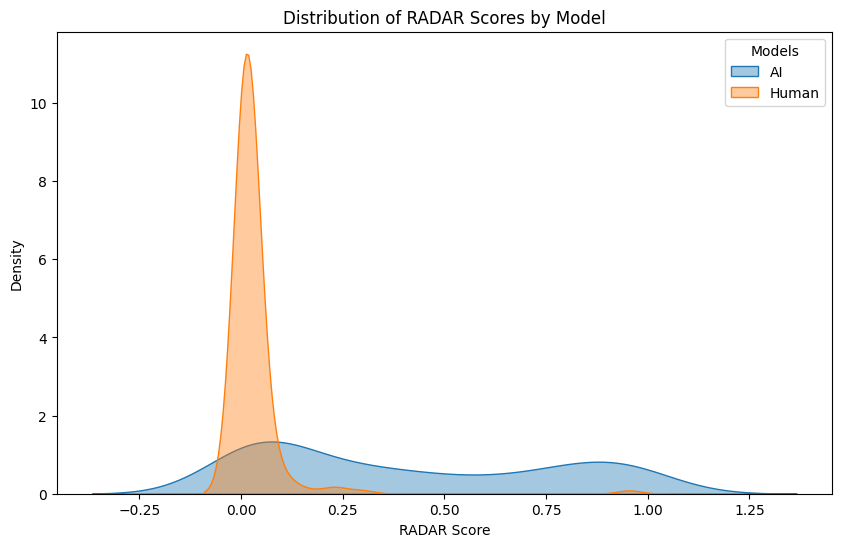

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Density")
plt.title("Distribution of RADAR Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

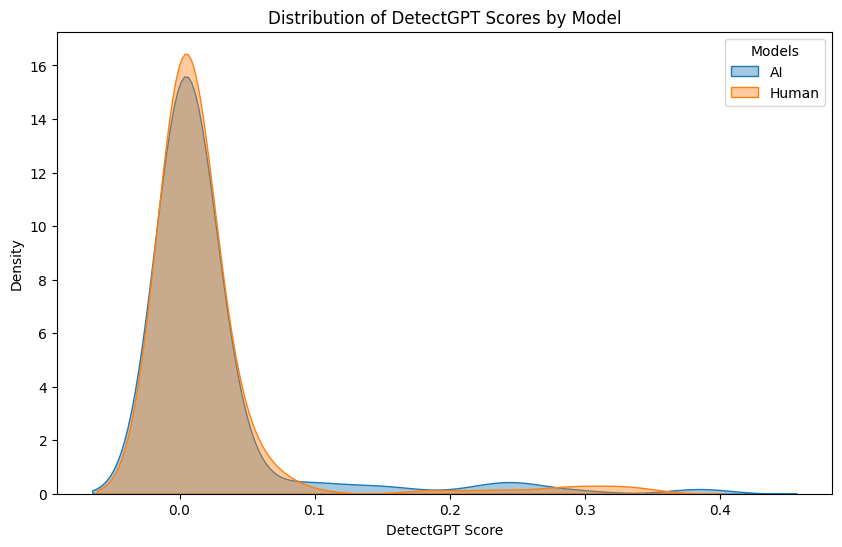

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Density")
plt.title("Distribution of DetectGPT Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

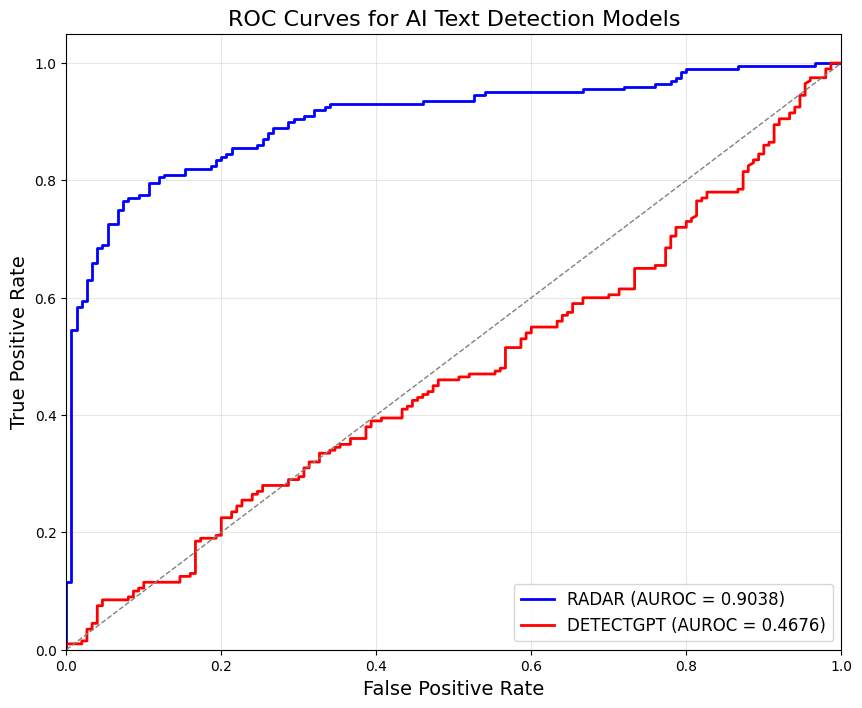

In [ ]:
from sklearn.metrics import roc_curve

# Calculate ROC curve points for both detectors
fpr_radar, tpr_radar, _ = roc_curve(combined_df['label'], combined_df['radar_score'])
fpr_wild, tpr_wild, _ = roc_curve(combined_df['label'], combined_df['detectgpt_score'])

# Create a figure with appropriate size
plt.figure(figsize=(10, 8))

# Plot both ROC curves
plt.plot(fpr_radar, tpr_radar, color='blue', lw=2,
         label=f'RADAR (AUROC = {auroc_radar:.4f})')
plt.plot(fpr_wild, tpr_wild, color='red', lw=2,
         label=f'DETECTGPT (AUROC = {auroc_detectgpt:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Add labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for AI Text Detection Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

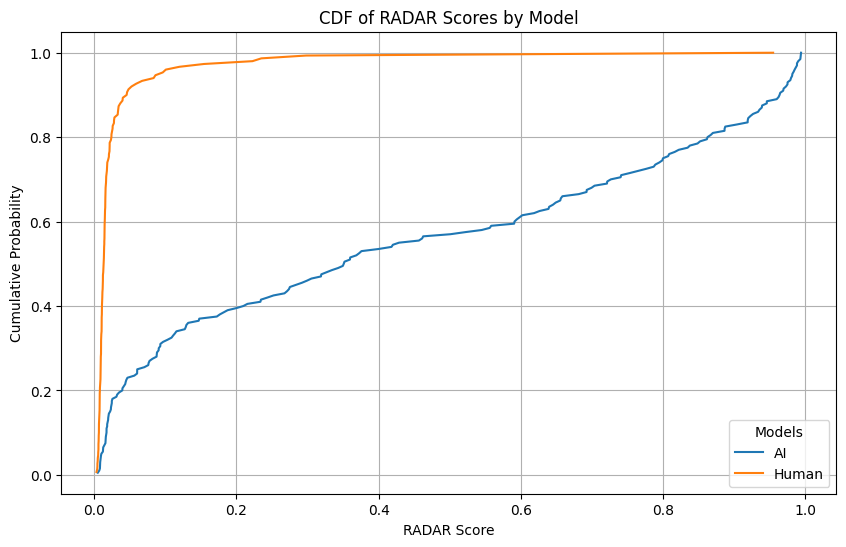

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of RADAR Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()


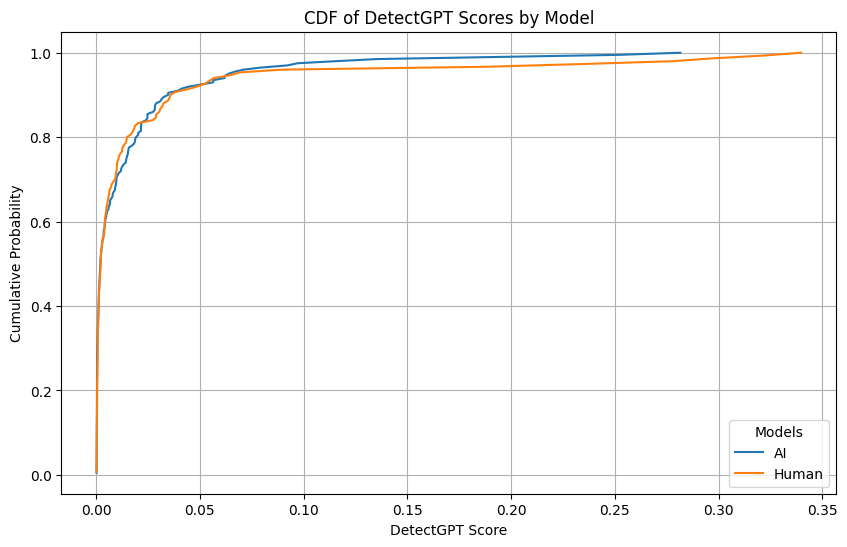

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of DetectGPT Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()